# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

import shap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.multiclass import OneVsRestClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from scipy.stats import t

from joblib import Parallel
from joblib import delayed
from tqdm_joblib import tqdm_joblib

from itertools import combinations

from collections import defaultdict

from tqdm.notebook import tqdm

In [2]:
warnings.filterwarnings("ignore")

np.seterr(all='ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/04a_modeling_lr'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 2551)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.086147,0.188129,0.527915,0.227357,0.030383,0.066351,0.186189,0.080186,0.030481,0.066564,0.186788,0.080444,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,14.571275,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.065641,0.134688,0.405704,0.187096,0.029668,0.060874,0.183365,0.084561,0.029835,0.061217,0.184397,0.085037,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,17.314756,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.078397,0.169022,0.534108,0.201333,0.032304,0.069647,0.220085,0.082961,0.032325,0.069691,0.220223,0.083013,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,12.422929,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
target = samples_description['Class']

In [9]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [11]:
sns.set_theme()

## Dictionaty for features mapping to type

In [12]:
feature_to_types = defaultdict(list)

for feature_type, features in features_description.items():
    for feature in features:
        feature_to_types[feature].append(feature_type)

## Dictionary for mapping *class* to *size group*

In [13]:
class_fraction_group_dict = {
    0: '$0< d \leq 2$',
    1: '$2 < d \leq 5$',
    2: '$d > 5$'
}

# Modeling

In [14]:
initial_features_df = features_df.copy()

print(initial_features_df.shape)
initial_features_df.head(3)

(75, 2551)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.086147,0.188129,0.527915,0.227357,0.030383,0.066351,0.186189,0.080186,0.030481,0.066564,0.186788,0.080444,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,14.571275,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.065641,0.134688,0.405704,0.187096,0.029668,0.060874,0.183365,0.084561,0.029835,0.061217,0.184397,0.085037,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,17.314756,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.078397,0.169022,0.534108,0.201333,0.032304,0.069647,0.220085,0.082961,0.032325,0.069691,0.220223,0.083013,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,12.422929,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## Target rate analysis

Mapping hue ~ group:
* Class 0 — $0< d \leq 2$
* Class 1 — $2 < d \leq 5$
* Class 2 — $d > 5$

In [15]:
target_rate_df = pd.DataFrame(samples_description['Fraction_grouped_hue'].value_counts()).sort_values(by='Fraction_grouped_hue')

target_rate_df.T

Fraction_grouped_hue,$0< d \leq 2$,$2 < d \leq 5$,$d > 5$
count,23,29,23


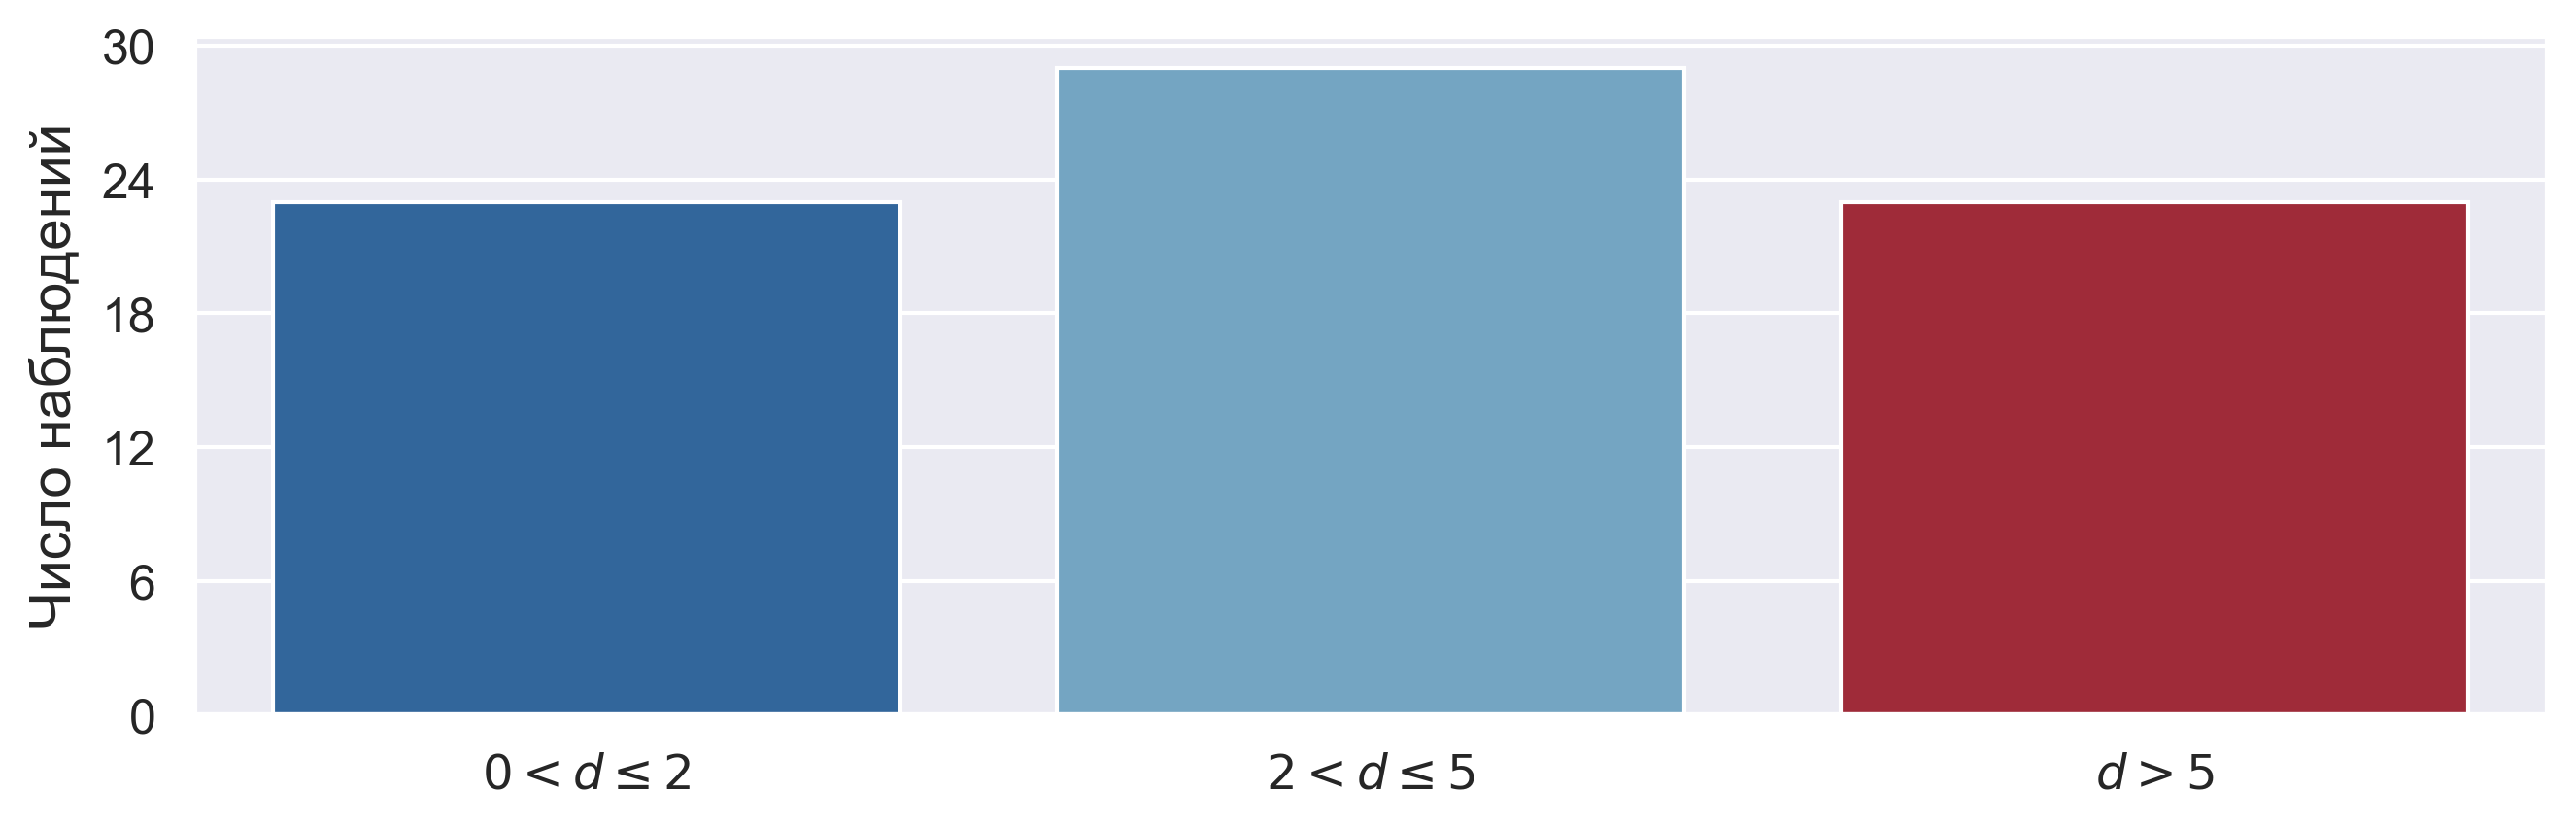

In [16]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

sns.barplot(
    data=target_rate_df,
    x='Fraction_grouped_hue',
    y='count',
    palette=type_color_dict,
    ax=ax
)

ax.set_xlabel('', fontsize=14, labelpad=5)
ax.set_ylabel('Число наблюдений', fontsize=14, labelpad=5)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()

plt.savefig(f'{path_to_save}/target_rate_barplot.png', dpi=600)

plt.show()

## *One-factor* analysis

### Calculation process

In [17]:
def of_analysis(feature, features_df, target, n_splits=5):
    X_raw = features_df[[feature]].values
    y = target.values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    mean_val, std_val = scaler.mean_[0], scaler.scale_[0]

    estimator = OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10_000, random_state=42))
    estimator.fit(X_scaled, y)
    
    try:
        y_score = estimator.predict_proba(X_scaled)
        metric_ovr = roc_auc_score(y, y_score, multi_class='ovr')
    except ValueError:
        metric_ovr = np.nan

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, test_idx in skf.split(X_raw, y):
        X_train, X_test = X_raw[train_idx], X_raw[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler_cv = StandardScaler()
        X_train_scaled = scaler_cv.fit_transform(X_train)
        X_test_scaled = scaler_cv.transform(X_test)

        estimator_cv = OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42))
        estimator_cv.fit(X_train_scaled, y_train)

        try:
            y_score_cv = estimator_cv.predict_proba(X_test_scaled)
            score = roc_auc_score(y_test, y_score_cv, multi_class='ovr')
        except ValueError:
            score = np.nan

        cv_scores.append(score)

    return {
        'Feature': feature,
        '$ROC-AUC_{ovr}$': metric_ovr,
        '$ROC-AUC_{ovr}^{CV}$': np.nanmean(cv_scores),
        '$mean$': mean_val,
        '$std$': std_val
    }

In [18]:
features_list = features_df.columns.tolist()

with tqdm_joblib(desc='Calculation progress', total=len(features_list)):
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(of_analysis)(
            feature,
            features_df,
            target,
            n_splits=5
        )
        for feature in features_list
    )

Calculation progress:   0%|          | 0/2551 [00:00<?, ?it/s]

In [19]:
of_metrics_df = pd.DataFrame(results)

of_metrics_df = of_metrics_df.sort_values(by=['$ROC-AUC_{ovr}^{CV}$', '$ROC-AUC_{ovr}$'], ascending=[False, False])

print(of_metrics_df.shape)
of_metrics_df.head(3)

(2551, 5)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovr}^{CV}$,$mean$,$std$
1021,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,0.873246,0.875019,0.994482,0.440713
1019,$\frac{I_{3132}}{I_{2926}}$,0.878196,0.873785,0.946547,0.468687
1020,$\frac{I_{3132}}{\overline{I}_{2926 \pm 25}}$,0.877946,0.873785,0.963022,0.459795


### Mapping features with their types

In [20]:
rows = []

for _, row in of_metrics_df.iterrows():
    feature = row['Feature']
    feature_types = feature_to_types.get(feature, [])

    for feature_type in feature_types:
        row_copy = row.copy()
        row_copy['Feature_Type'] = feature_type
        rows.append(row_copy)

of_metrics_expanded_df = pd.DataFrame(rows)

print(of_metrics_expanded_df.shape)
of_metrics_expanded_df.head(3)

(5102, 6)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovr}^{CV}$,$mean$,$std$,Feature_Type
1021,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,0.873246,0.875019,0.994482,0.440713,engineered_features_intervals_3800_2200
1021,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,0.873246,0.875019,0.994482,0.440713,engineered_features
1019,$\frac{I_{3132}}{I_{2926}}$,0.878196,0.873785,0.946547,0.468687,engineered_features_peaks_3800_2200


### Visualization

In [21]:
feature_types = [
    'base_features_peaks_3800_2200',
    'base_features_intervals_3800_2200',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2200',
    'engineered_features_intervals_3800_2200',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [22]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 16,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 8,
    'X_NBINS': 8,
    'BAR_WIDTH': 0.7,
    'BAR_ALPHA': 0.85,
    'FIG_DPI': 300,
    'SUBPLOT_WIDTH': 5,
    'SUBPLOT_HEIGHT': 4,
    'TOP_N': 5,
    'COLOR_MAP': {
        'base': 'royalblue',
        'engineered': 'seagreen'
    },
    'LEGEND_FONT_SIZE': 12
}

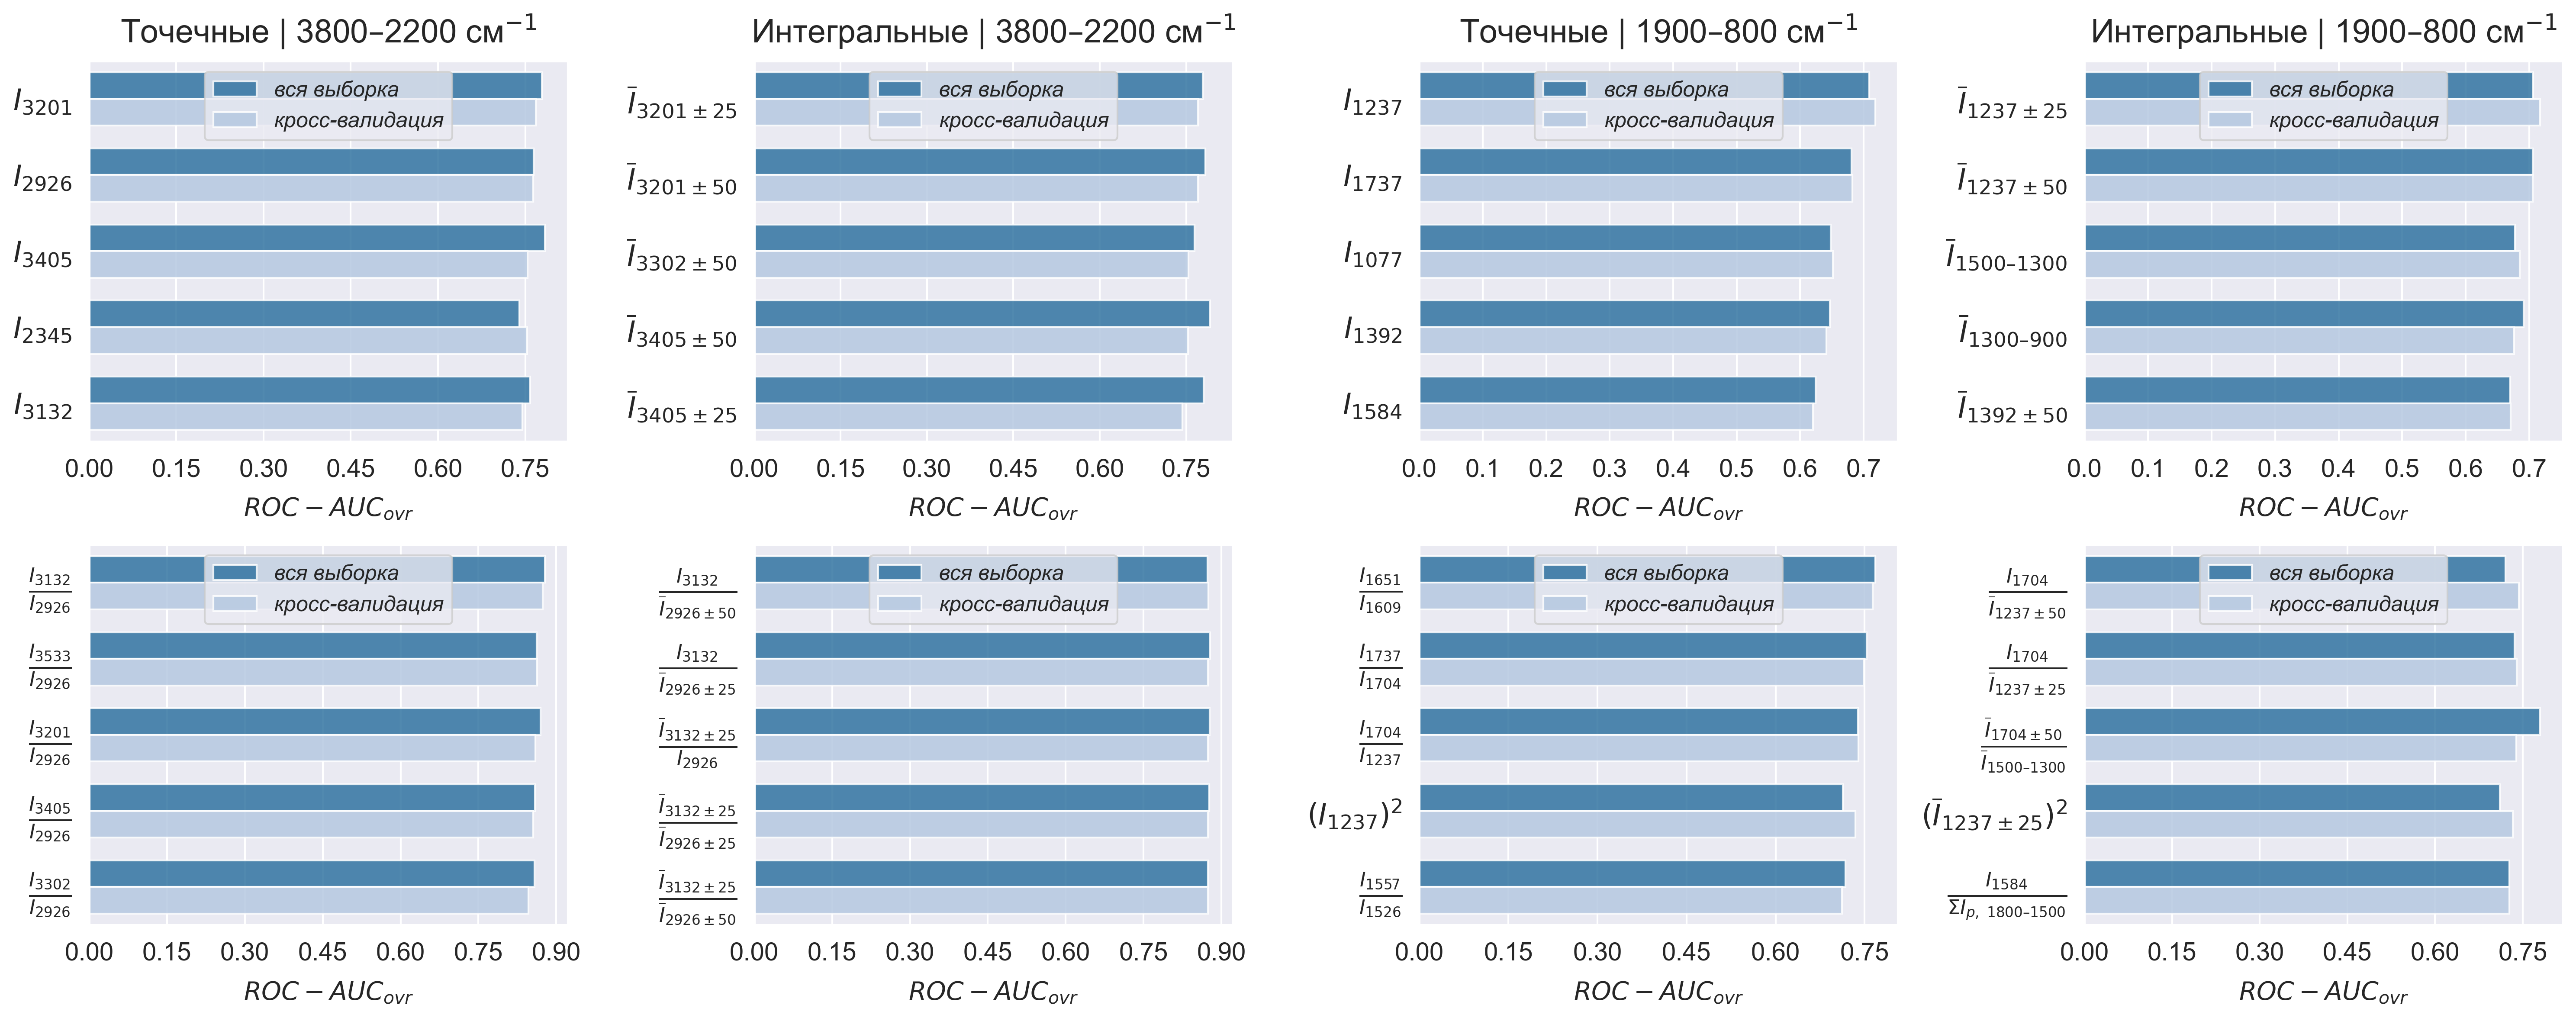

In [23]:
nrows, ncols = 2, 4

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * PLOT_STYLE['SUBPLOT_WIDTH'], nrows * PLOT_STYLE['SUBPLOT_HEIGHT']),
    dpi=PLOT_STYLE['FIG_DPI']
)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    subset = of_metrics_expanded_df[of_metrics_expanded_df['Feature_Type'] == feature_type]
    
    result_df = (
        subset
        .sort_values(
            by=['$ROC-AUC_{ovr}^{CV}$', '$ROC-AUC_{ovr}$'],
            ascending=[False, False]
        )
        .head(PLOT_STYLE['TOP_N'])
        .copy()
    )

    result_df = result_df[['Feature', '$ROC-AUC_{ovr}$', '$ROC-AUC_{ovr}^{CV}$']]
    
    result_df = result_df.melt(id_vars='Feature', var_name='Type', value_name='ROC-AUC')
    result_df['Type'] = result_df['Type'].map({
        '$ROC-AUC_{ovr}$': 'вся выборка',
        '$ROC-AUC_{ovr}^{CV}$': 'кросс-валидация'
    })

    kind = 'engineered' if 'engineered' in feature_type else 'base'
    color = PLOT_STYLE['COLOR_MAP'][kind]

    ax = axes[i]
    
    sns.barplot(
        data=result_df,
        x='ROC-AUC',
        y='Feature',
        hue='Type',
        ax=ax,
        palette=['#1f77b4', '#aec7e8'],
        width=PLOT_STYLE['BAR_WIDTH'],
        alpha=PLOT_STYLE['BAR_ALPHA']
    )

    if i < 4:
        label = 'Точечные' if 'peaks' in feature_type else 'Интегральные'
        a, b = [s for s in feature_type.split('_') if s.isdigit()][-2:]
        title = f'{label} | {a}–{b} см$^{{-1}}$'
        
        ax.set_title(
            title,
            fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
            fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
            pad=10
        )

    ax.set_xlabel('$ROC-AUC_{ovr}$', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    legend = ax.legend(loc='upper center', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'], frameon=True)
    for text in legend.get_texts():
        text.set_fontstyle('italic')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# plt.savefig(f'{path_to_save}/roc_auc_barplots.png', dpi=600)

plt.show()

### *Hard-check* factor selection

In [24]:
of_features_to_save = (
    of_metrics_df
    .loc[
        (of_metrics_df['$ROC-AUC_{ovr}$'] >= 0.70)
        & (of_metrics_df['$ROC-AUC_{ovr}^{CV}$'] >= 0.70)
        & (of_metrics_df['$ROC-AUC_{ovr}^{CV}$'] - of_metrics_df['$ROC-AUC_{ovr}$'] >= -0.05)
    ]['Feature']
).tolist()

print(
    f'Число фичей',
    f'(*) до отбора: {len(of_metrics_df["Feature"].unique())}',
    f'(*) после отбора: {len(of_features_to_save)}',
    f'Доля фичей, прошедших однофакторный отбор: {round(len(of_features_to_save) / len(of_metrics_df["Feature"].unique()) * 100, 2)}%',
    sep='\n'
)

Число фичей
(*) до отбора: 2551
(*) после отбора: 496
Доля фичей, прошедших однофакторный отбор: 19.44%


## *Multi-factor* analysis

### Functions for processing & config-parameters

In [25]:
PLOT_STYLE = {
    'TITLE': '',
    'TITLE_FONT_SIZE': 12,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 10,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'METRIC_VALUE_FONT_SIZE': 8,
    'Y_NBINS': 10
}

#### Forward selection

In [26]:
def forward_selection_parallel(
    features_df,
    target,
    candidate_features,
    scoring='roc_auc_ovr',
    min_uplift=None,
    max_features=None,
    use_cv=True,
    cv_folds=5,
    n_jobs=-1,
    use_tqdm=True
):
    selected, best_score, history = [], -np.inf, []
    remain = candidate_features.copy()

    def compute_score_for_feature(feat, current_selected):
        feats = current_selected + [feat]
        X = features_df[feats].values
        y = target.values

        estimator = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, random_state=42)))
        ])

        if use_cv:
            scores = []
            skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            for train_idx, test_idx in skf.split(X, y):
                estimator.fit(X[train_idx], y[train_idx])
                y_pred = estimator.predict_proba(X[test_idx])
                try:
                    match scoring:
                        case 'roc_auc_ovr': score = roc_auc_score(y[test_idx], y_pred, multi_class='ovr')
                        case 'roc_auc_ovr': score = roc_auc_score(y[test_idx], y_pred, multi_class='ovr')
                        case 'pr_auc': score = average_precision_score(y[test_idx], y_pred, average='macro')
                        case _: raise ValueError(f'Unsupported metric: {scoring}')
                    scores.append(score)
                except:
                    continue
            return (feat, np.nanmean(scores))
        else:
            estimator.fit(X, y)
            y_pred = estimator.predict_proba(X)
            match scoring:
                case 'roc_auc_ovr': score = roc_auc_score(y, y_pred, multi_class='ovr')
                case 'roc_auc_ovr': score = roc_auc_score(y, y_pred, multi_class='ovr')
                case 'pr_auc': score = average_precision_score(y, y_pred, average='macro')
                case _: raise ValueError(f'Unsupported metric: {scoring}')
            return (feat, score)

    while remain:
        tqdm_iter = tqdm(remain, desc=f'Step {len(selected)+1}') if use_tqdm else remain

        results = Parallel(n_jobs=n_jobs)(
            delayed(compute_score_for_feature)(feat, selected) for feat in tqdm_iter
        )

        results = [r for r in results if r[1] is not None]
        if not results:
            break

        feat_best, score_best = max(results, key=lambda x: x[1])
        uplift = score_best - best_score

        if min_uplift is not None and uplift < min_uplift:
            break

        selected.append(feat_best)
        remain.remove(feat_best)
        best_score = score_best
        history.append({'feature': feat_best, 'score': score_best, 'uplift': uplift})

        if max_features is not None and len(selected) >= max_features:
            break

    return selected, history

#### Labels correction

In [27]:
def simplify_frac(label):
    return re.sub(r'\\frac\{(.+?)\}\{(.+?)\}', r'\1 / \2', label)

#### *Metric-uplift* bar plot

In [28]:
def plot_cumulative_score_bar(selection_log, ax=None):
    df_log = pd.DataFrame(selection_log)
    df_log['Step'] = range(1, len(df_log) + 1)
    df_log['Cumulative Score'] = df_log['score']
    df_log['Base'] = df_log['Cumulative Score'].shift(fill_value=0)
    df_log['Gain'] = df_log['Cumulative Score'] - df_log['Base']

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(len(df_log) * 1.5, 5), dpi=150)
        created_fig = True

    for i, row in df_log.iterrows():
        ax.bar(
            x=row['feature'],
            height=row['Gain'],
            bottom=row['Base'],
            width=0.4,
            color=sns.color_palette('crest', n_colors=len(df_log))[i]
        )
        ax.text(
            i,
            row['Cumulative Score'] + 0.001,
            f'{row["Cumulative Score"]:.3f}',
            ha='center',
            va='bottom',
            fontsize=PLOT_STYLE['METRIC_VALUE_FONT_SIZE']
        )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'], rotation=0)
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'Y_NBINS' in PLOT_STYLE:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['Y_NBINS']))

    ax.set_xticks(range(len(df_log)))
    ax.set_xticklabels(df_log['feature'])

    if created_fig:
        plt.tight_layout()
        plt.show()

#### *Metric-uplift* line plot

In [29]:
def plot_cumulative_score_line(selection_log, ax=None):
    df_log = pd.DataFrame(selection_log)
    df_log['Step'] = range(1, len(df_log) + 1)
    df_log['Cumulative Score'] = df_log['score']

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(len(df_log) * 1.5, 5), dpi=150)
        created_fig = True

    ax.plot(df_log['Step'], df_log['Cumulative Score'], marker='o', linewidth=2)

    for i, row in df_log.iterrows():
        ax.text(
            row['Step'],
            row['Cumulative Score'] + 0.001,
            f'{row["Cumulative Score"]:.3f}',
            ha='center',
            va='bottom',
            fontsize=PLOT_STYLE['METRIC_VALUE_FONT_SIZE']
        )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'Y_NBINS' in PLOT_STYLE:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['Y_NBINS']))

    ax.set_xticks(df_log['Step'])
    ax.set_xticklabels(df_log['feature'], rotation=0)

    if created_fig:
        plt.tight_layout()
        plt.show()

### `3800-2200` cm$^{–1}$

In [30]:
candidate_features_3800_2200 = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        if '3800_2200' in feature_type:
            candidate_features_3800_2200.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features_3800_2200)}')

Число фичей для многофакторного анализа: 458


In [31]:
%%time

selected_feats_3800_2200, selection_log_3800_2200 = forward_selection_parallel(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_3800_2200,
    scoring='roc_auc_ovr',
    min_uplift=0.002,
    max_features=5,
    use_cv=True,
    cv_folds=5,
    n_jobs=-1
)

Step 1:   0%|          | 0/458 [00:00<?, ?it/s]

Step 2:   0%|          | 0/457 [00:00<?, ?it/s]

Step 3:   0%|          | 0/456 [00:00<?, ?it/s]

Step 4:   0%|          | 0/455 [00:00<?, ?it/s]

Step 5:   0%|          | 0/454 [00:00<?, ?it/s]

CPU times: user 2.64 s, sys: 361 ms, total: 3 s
Wall time: 31.3 s


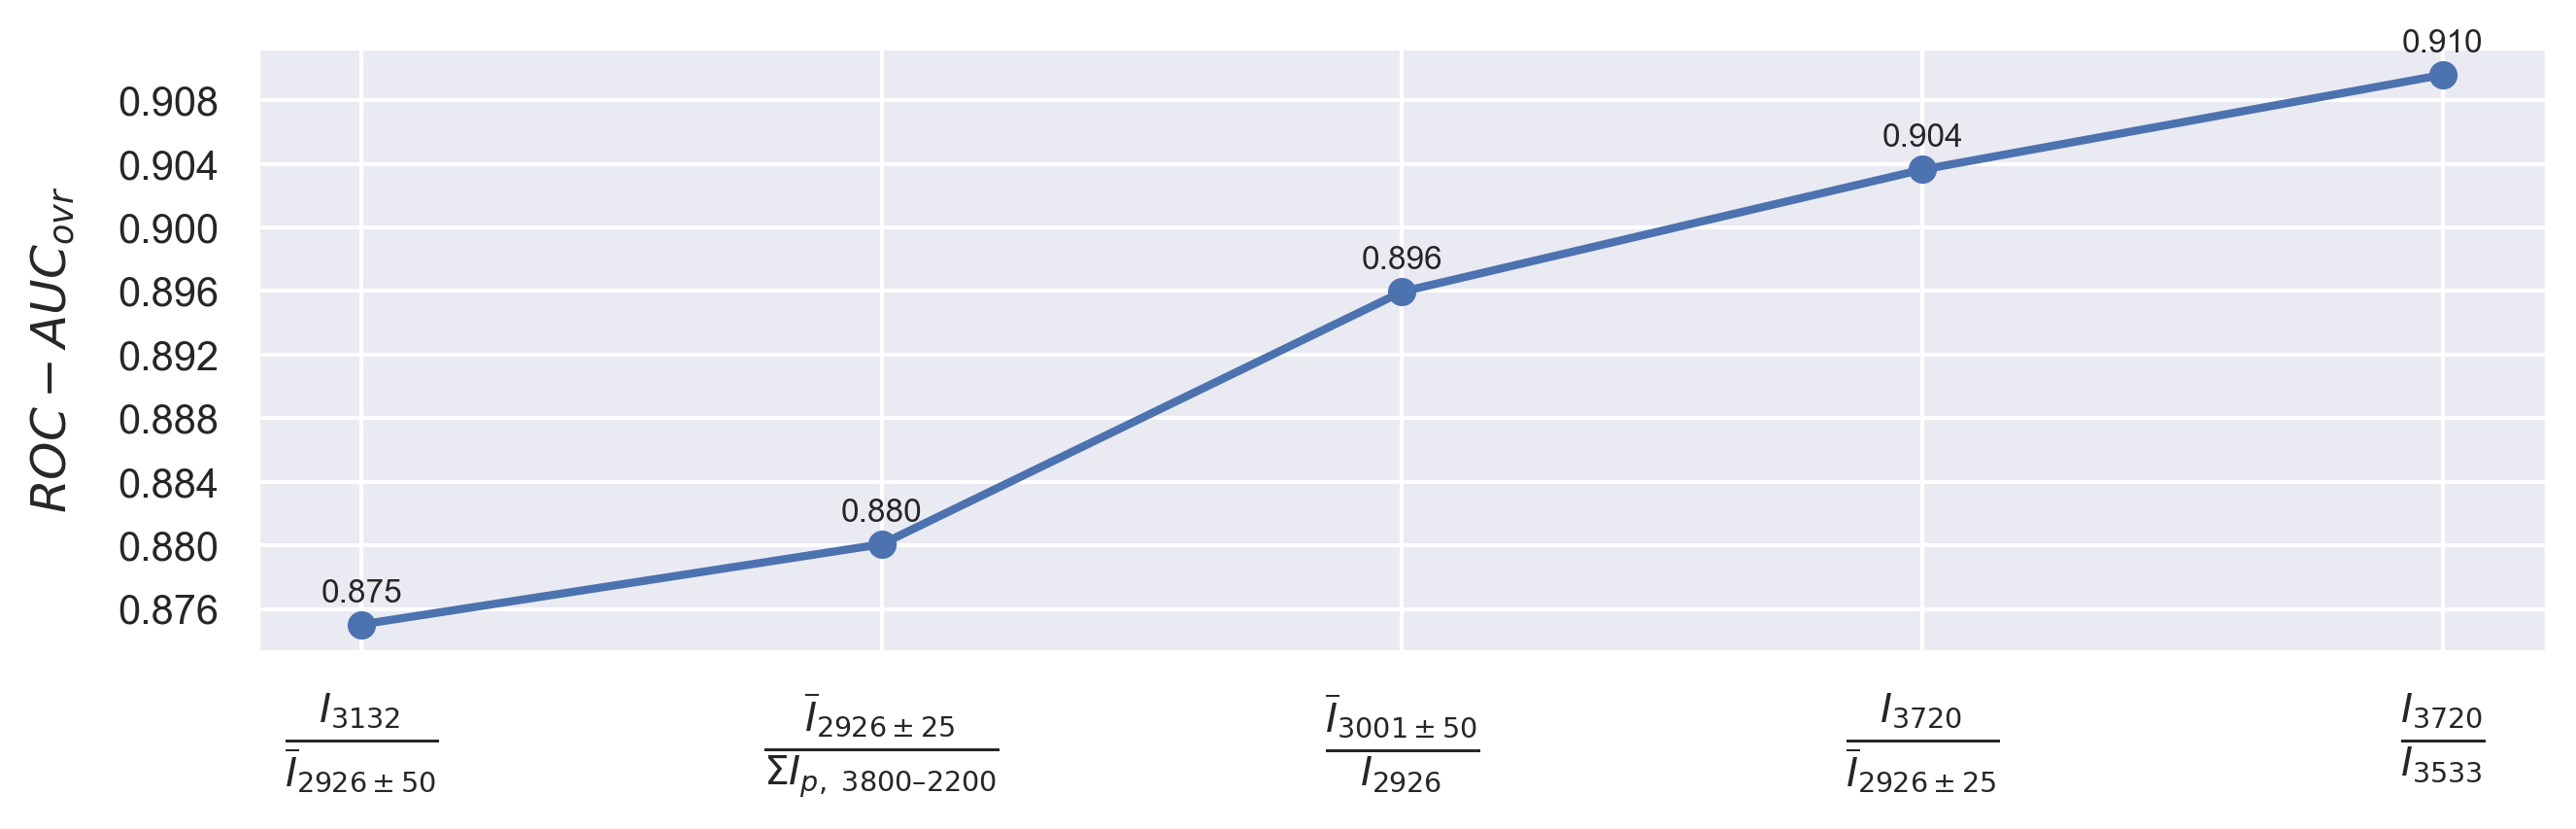

In [32]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line(
    selection_log=selection_log_3800_2200,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fs_3800_2200_uplift_lineplot.png', dpi=600)

plt.show()

### `1900-800` cm$^{–1}$

#### Feature selection process

In [33]:
candidate_features_1900_800 = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        if '1900_800' in feature_type:
            candidate_features_1900_800.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features_1900_800)}')

Число фичей для многофакторного анализа: 38


In [34]:
%%time

selected_feats_1900_800, selection_log_1900_800 = forward_selection_parallel(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_1900_800,
    scoring='roc_auc_ovr',
    min_uplift=0.002,
    max_features=5,
    use_cv=True,
    cv_folds=5,
    n_jobs=-1
)

Step 1:   0%|          | 0/38 [00:00<?, ?it/s]

Step 2:   0%|          | 0/37 [00:00<?, ?it/s]

Step 3:   0%|          | 0/36 [00:00<?, ?it/s]

Step 4:   0%|          | 0/35 [00:00<?, ?it/s]

Step 5:   0%|          | 0/34 [00:00<?, ?it/s]

CPU times: user 354 ms, sys: 55.7 ms, total: 410 ms
Wall time: 2.7 s


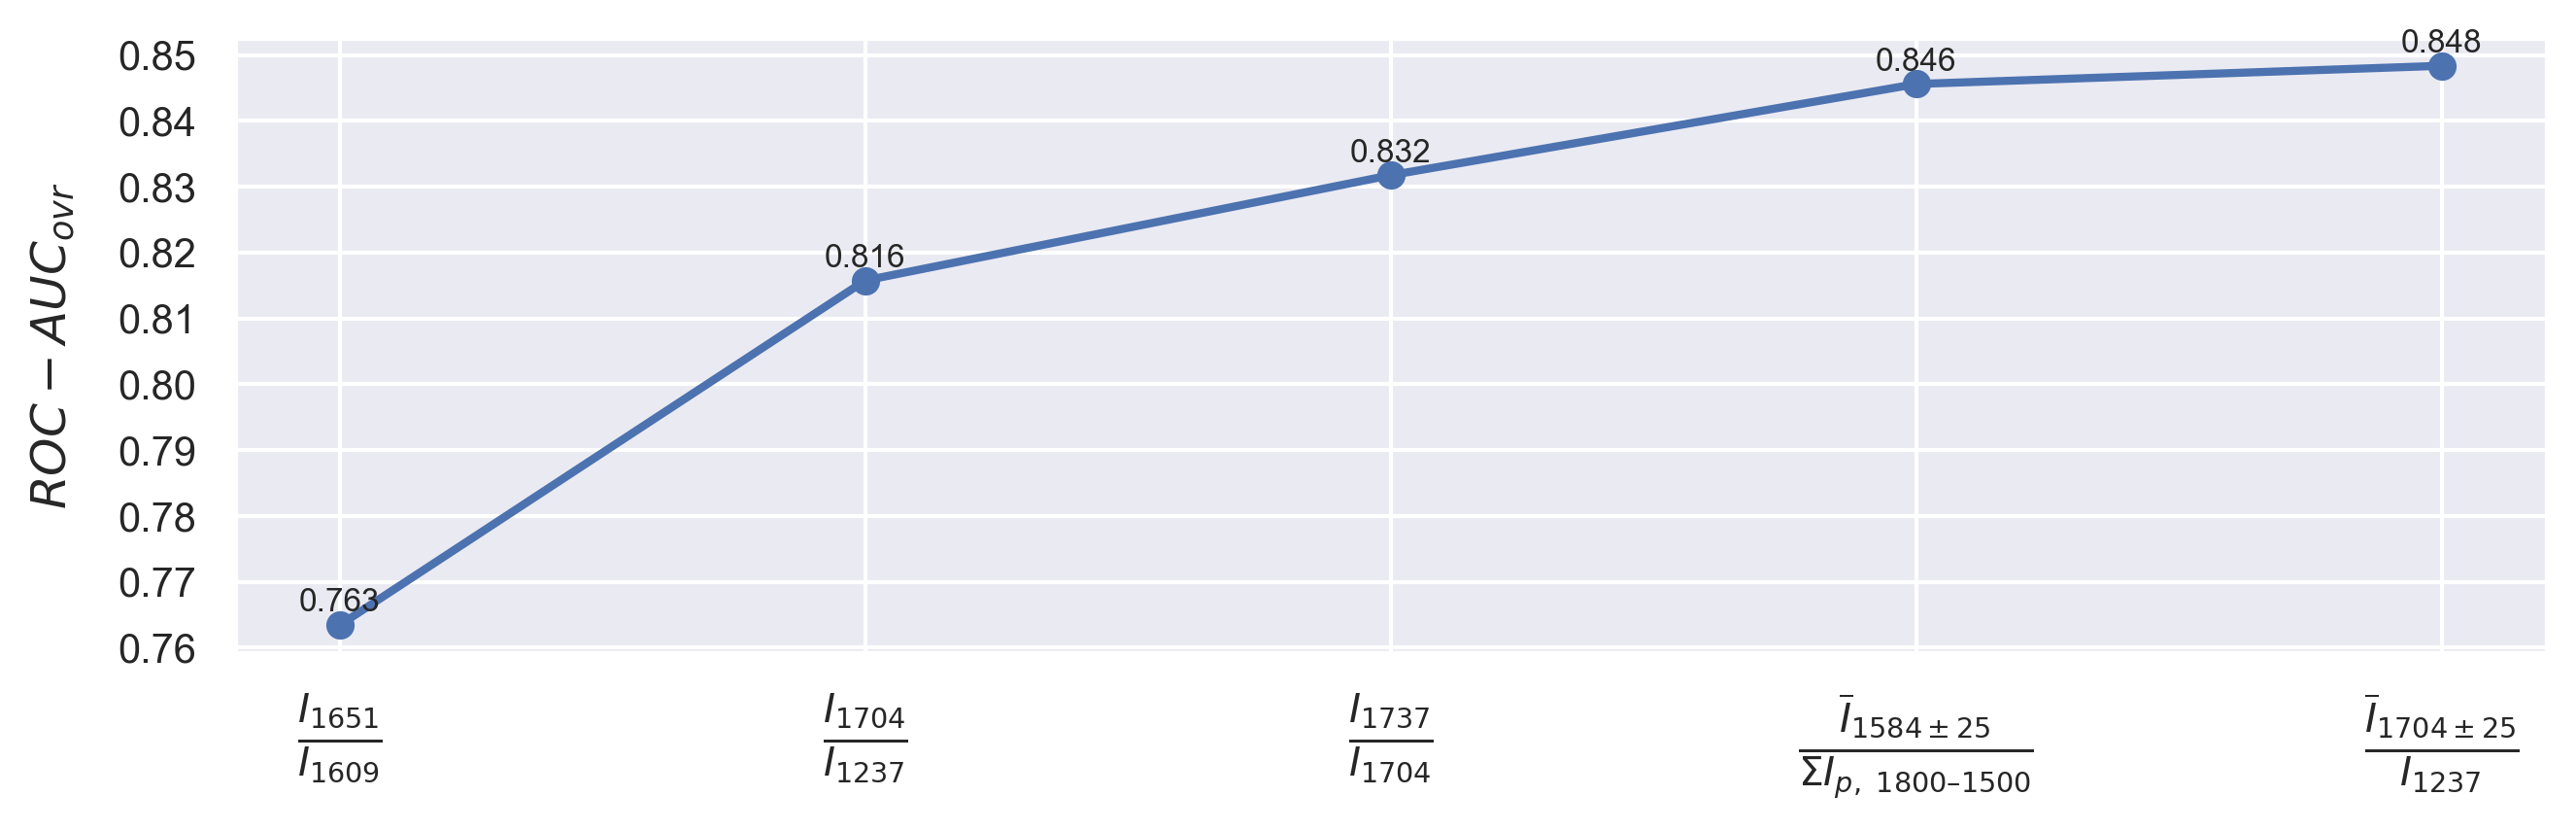

In [35]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line(
    selection_log=selection_log_1900_800,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fs_1900_800_uplift_lineplot.png', dpi=600)

plt.show()

### `3800-2200` x `1900-800` cm$^{–1}$

In [36]:
candidate_features_3800_2200_1900_800 = of_features_to_save.copy()

print(f'Число фичей для многофакторного анализа: {len(candidate_features_3800_2200_1900_800)}')

Число фичей для многофакторного анализа: 496


In [37]:
%%time

selected_feats_3800_2200_1900_800, selection_log_3800_2200_1900_800 = forward_selection_parallel(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_3800_2200_1900_800,
    scoring='roc_auc_ovr',
    min_uplift=0.002,
    max_features=5,
    use_cv=True,
    cv_folds=5,
    n_jobs=-1
)

Step 1:   0%|          | 0/496 [00:00<?, ?it/s]

Step 2:   0%|          | 0/495 [00:00<?, ?it/s]

Step 3:   0%|          | 0/494 [00:00<?, ?it/s]

Step 4:   0%|          | 0/493 [00:00<?, ?it/s]

Step 5:   0%|          | 0/492 [00:00<?, ?it/s]

CPU times: user 4.02 s, sys: 569 ms, total: 4.58 s
Wall time: 44.9 s


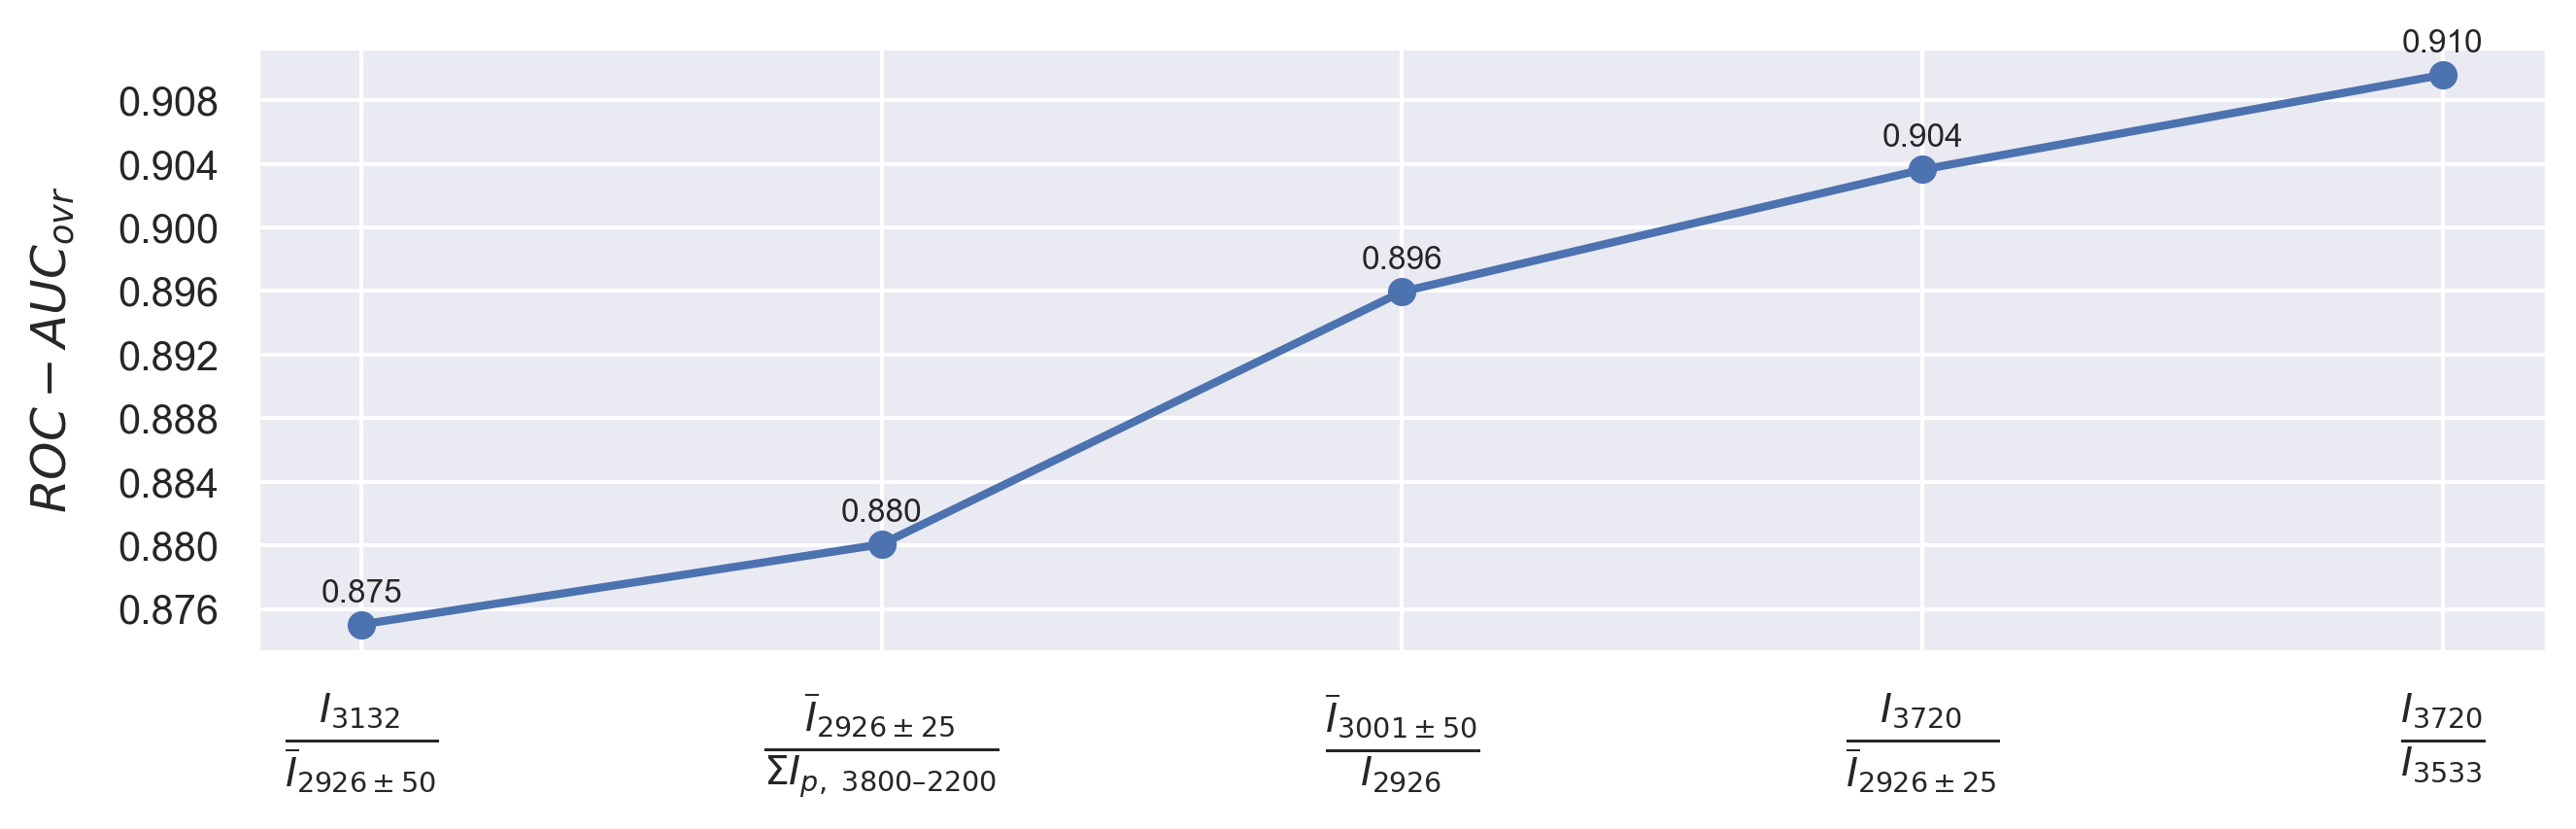

In [38]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line(
    selection_log=selection_log_3800_2200_1900_800,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fs_3800_2200_1900_800_uplift_lineplot.png', dpi=600)

plt.show()

## Models analysis

### Functions for processing

#### Modeling process (*scaling, `lr` fitting, cross-validation, metrics calculation*)

In [39]:
def logreg_analysis(df, feature_list, target, cv_folds=5, random_state=42, optimize_C=False, C_values=None, scoring_metric='roc_auc_ovr'):
    X = df[feature_list].copy()
    y = target.copy()

    def roc_auc_ovr_metric(estimator, X, y_true):
        y_pred_proba = estimator.predict_proba(X)
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')

    def pr_auc_macro_metric(estimator, X, y_true):
        y_pred_proba = estimator.predict_proba(X)
        return average_precision_score(y_true, y_pred_proba, average='macro')

    def ci95(series):
        mean = np.mean(series)
        std = np.std(series, ddof=1)
        n = len(series)
        t_score = t.ppf(0.975, df=n - 1)
        margin = t_score * std / np.sqrt(n)
        return mean, margin

    best_C = 1.0
    c_metric_df = None

    if optimize_C:
        if C_values is None:
            C_values = np.logspace(-4, 4, 100)
        
        metric_values_lst = []
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

        for C in tqdm(C_values, desc='Inverse of regularization strength optimization'):
            scores = []
            for train_idx, test_idx in skf.split(X, y):
                X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
                y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

                scaler_cv = StandardScaler()
                X_train_scaled = scaler_cv.fit_transform(X_train_cv)
                X_test_scaled = scaler_cv.transform(X_test_cv)

                clf_cv = OneVsRestClassifier(LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000, random_state=random_state))
                clf_cv.fit(X_train_scaled, y_train_cv)
                y_pred_proba_cv = clf_cv.predict_proba(X_test_scaled)

                if scoring_metric == 'roc_auc_ovr':
                    score = roc_auc_score(y_test_cv, y_pred_proba_cv, multi_class='ovr', average='macro')
                elif scoring_metric == 'pr_auc_macro':
                    score = average_precision_score(y_test_cv, y_pred_proba_cv, average='macro')
                else:
                    raise ValueError("Unsupported scoring metric")

                scores.append(score)

            metric_values_lst.append(np.mean(scores))

        c_metric_df = pd.DataFrame({'C': C_values, scoring_metric: metric_values_lst})
        best_C = c_metric_df.loc[c_metric_df[scoring_metric].idxmax(), 'C']

    clf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, C=best_C, random_state=random_state)))
    ])
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    cv_results = cross_validate(
        clf_pipeline, X, y,
        cv=skf,
        scoring={
            'roc_auc_ovr': roc_auc_ovr_metric,
            'pr_auc_macro': pr_auc_macro_metric
        },
        return_train_score=False
    )

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_list, index=X.index)
    clf = OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, C=best_C, random_state=random_state))
    clf.fit(X_scaled, y)
    y_proba = clf.predict_proba(X_scaled)

    roc_auc_full = roc_auc_score(y, y_proba, multi_class='ovr', average='macro')
    pr_auc_full = average_precision_score(y, y_proba, average='macro')

    coef_df = pd.DataFrame(
        [est.coef_.flatten() for est in clf.estimators_],
        columns=feature_list,
        index=[f'Class {c}' for c in clf.classes_]
    )
    
    intercepts = [est.intercept_[0] for est in clf.estimators_]
    coef_df['Intercept'] = intercepts

    scaler_df = pd.DataFrame({'Feature': feature_list, 'Mean': scaler.mean_, 'Std': scaler.scale_})

    roc_auc_mean, roc_auc_ci = ci95(cv_results['test_roc_auc_ovr'])
    pr_auc_mean, pr_auc_ci = ci95(cv_results['test_pr_auc_macro'])

    metrics_df = pd.DataFrame({
        '$ROC-AUC_{ovr}$': {
            'Mean': roc_auc_mean,
            '$CI_{95, cv}$': roc_auc_ci,
            '$all$ $sample$': roc_auc_full
        },
        '$PR-AUC_{macro}$': {
            'Mean': pr_auc_mean,
            '$CI_{95, cv}$': pr_auc_ci,
            '$all$ $sample$': pr_auc_full
        }
    })

    return clf, X_scaled, scaler_df, coef_df, metrics_df, best_C, c_metric_df

#### `C` optimaztion visualization

In [40]:
def plot_c_metric_curve(c_metric_df, metric_name='roc_auc_ovr', best_C=None, ax=None):
    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300) if not external_ax else (None, ax)

    sns.lineplot(
        data=c_metric_df,
        x='C',
        y=metric_name,
        color='teal',
        linewidth=3.5,
        ax=ax
    )

    ax.set_xscale('log')

    # Отметим лучшую C
    if best_C is not None:
        best_y = c_metric_df.loc[c_metric_df['C'] == best_C, metric_name].values
        if len(best_y):
            ax.axvline(x=best_C, color='darkred', linestyle='--', linewidth=1.8)
            ax.scatter(best_C, best_y[0], color='darkred', s=50, zorder=5)

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if not external_ax:
        plt.tight_layout()
        plt.show()

#### *ROC*-curves visualization

In [41]:
def plot_roc_curve_per_class(model, X_scaled, y_true, class_index, ax):
    y_score = model.predict_proba(X_scaled)
    classes = model.classes_
    y_bin = label_binarize(y_true, classes=classes)

    fpr, tpr, _ = roc_curve(y_bin[:, class_index], y_score[:, class_index])
    roc_auc = auc(fpr, tpr)

    class_label = class_fraction_group_dict[class_index]
    class_color = type_color_dict[class_label]

    ax.plot(
        fpr,
        tpr,
        color=class_color,
        linewidth=PLOT_STYLE['LINE_WIDTH'],
        label=fr'$ROC\text{{-}}AUC_{{ovr}} = {roc_auc:.2f}$'
    )

    ax.plot(
        [0, 1],
        [0, 1],
        linestyle='--',
        color='gray',
        linewidth=PLOT_STYLE['LINE_WIDTH'] - 1.5,
        label='$ROC-AUC = 0.50$\n$(random$ $classifier)$'
    )

    ax.set_title(class_label, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if 'Y_NBINS' in PLOT_STYLE:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['Y_NBINS']))
    
    ax.legend(loc='lower right', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'])

#### *SHAP*-values visualization (*beeswarm*)

In [42]:
def plot_shap_summary_logreg(model, X_scaled, features_lst, class_index=0, max_display=20, show_colorbar=True, ax=None):
    base_model = model.estimators_[class_index] if hasattr(model, 'estimators_') else model

    explainer = shap.LinearExplainer(base_model, X_scaled, feature_perturbation='interventional')
    shap_values = explainer(X_scaled)
    shap_values.feature_names = list(features_lst)

    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)

    shap.plots.beeswarm(
        shap_values,
        max_display=max_display,
        show=False,
        color_bar=show_colorbar,
        ax=ax,
        s=PLOT_STYLE['DOT_SIZE'],
        plot_size=None
    )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if show_colorbar:
        fig = plt.gcf()
        for other_ax in fig.axes:
            if other_ax is not ax and len(other_ax.get_xticks()) == 0 and len(other_ax.get_yticks()) > 0:
                other_ax.set_ylabel(PLOT_STYLE['LEGEND_TITLE'], fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'])
                other_ax.tick_params(labelsize=PLOT_STYLE['LEGEND_FONT_SIZE'])

                if 'COLORBAR_TICKS' in PLOT_STYLE:
                    other_ax.set_yticklabels(PLOT_STYLE['COLORBAR_TICKS'])

    if not external_ax:
        plt.tight_layout()
        plt.show()

#### Feature importance (feature weight) barplot

In [43]:
def plot_feature_importance_logreg(model, features_lst, max_display=20, ax=None):
    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)

    # Поддержка OneVsRestClassifier
    if hasattr(model, 'estimators_'):
        coefs = np.vstack([est.coef_ for est in model.estimators_])
    else:
        coefs = model.coef_

    importance = np.abs(coefs).mean(axis=0)
    rel_importance = 100 * importance / importance.sum()

    rel_series = pd.Series(rel_importance, index=features_lst).sort_values(ascending=False).head(max_display)

    palette = sns.color_palette(PLOT_STYLE['PALETTE'], n_colors=len(rel_series))
    colors = list(palette)[::-1]  # от меньшего к большему по Y

    rel_series[::-1].plot(kind='barh', ax=ax, color=colors)

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if not external_ax:
        plt.tight_layout()
        plt.show()

### `3800-2200` cm$^{-1}$

In [44]:
range = '3800_2200'

#### Model fitting

In [45]:
model, X_scaled, scaler_df, coef_df, metrics_df, best_C, c_metric_df = logreg_analysis(
    df=features_df,
    feature_list=selected_feats_3800_2200,
    target=target,
    optimize_C=True,
    scoring_metric='roc_auc_ovr'
)

print(X_scaled.shape)
X_scaled.head(3)

Inverse of regularization strength optimization:   0%|          | 0/100 [00:00<?, ?it/s]

(75, 5)


,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,"$\frac{\overline{I}_{2926 \pm 25}}{\Sigma I_{p,\ 3800\text{–}2200}}$",$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{I_{3720}}{\overline{I}_{2926 \pm 25}}$,$\frac{I_{3720}}{I_{3533}}$
division_1_size_bulk,1.589387,-1.093607,1.234090,-0.042059,-0.650839
division_1_size_5,1.383788,-1.030590,0.933462,-0.649566,-0.918266
division_1_size_3,0.587596,-0.743796,0.108045,-0.361637,-0.755640


*Parameters for scaling*

In [46]:
display(scaler_df.T)

,0,1,2,3,4
Feature,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,"$\frac{\overline{I}_{2926 \pm 25}}{\Sigma I_{p,\ 3800\text{–}2200}}$",$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{I_{3720}}{\overline{I}_{2926 \pm 25}}$,$\frac{I_{3720}}{I_{3533}}$
Mean,0.994482,0.13069,0.833819,0.207912,0.430696
Std,0.440713,0.051839,0.286093,0.187975,0.405258


*Model parameters (weights & intercept)*

In [47]:
display(coef_df)

,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,"$\frac{\overline{I}_{2926 \pm 25}}{\Sigma I_{p,\ 3800\text{–}2200}}$",$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{I_{3720}}{\overline{I}_{2926 \pm 25}}$,$\frac{I_{3720}}{I_{3533}}$,Intercept
Class 0,-1.887715,1.689038,1.484185,-0.366291,1.002657,-1.713329
Class 1,-1.728693,-2.189519,-1.349991,0.761588,-1.524085,-0.606514
Class 2,-0.224250,0.751707,6.700139,-1.279639,-1.087730,-5.803046


*Model metrics*

In [48]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Mean,0.902200,0.858813
"$CI_{95, cv}$",0.071416,0.099513
$all$ $sample$,0.918771,0.862217


*Optimal inverse of regulation strength value*

#### Visualization of `C` optimization

In [49]:
print(f'Optimal value of regularization coefficient (C): {round(best_C, 4)}')

Optimal value of regularization coefficient (C): 14.8497


In [50]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3.3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Обратный коэффициент регуляризации ($C$)',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 11
}

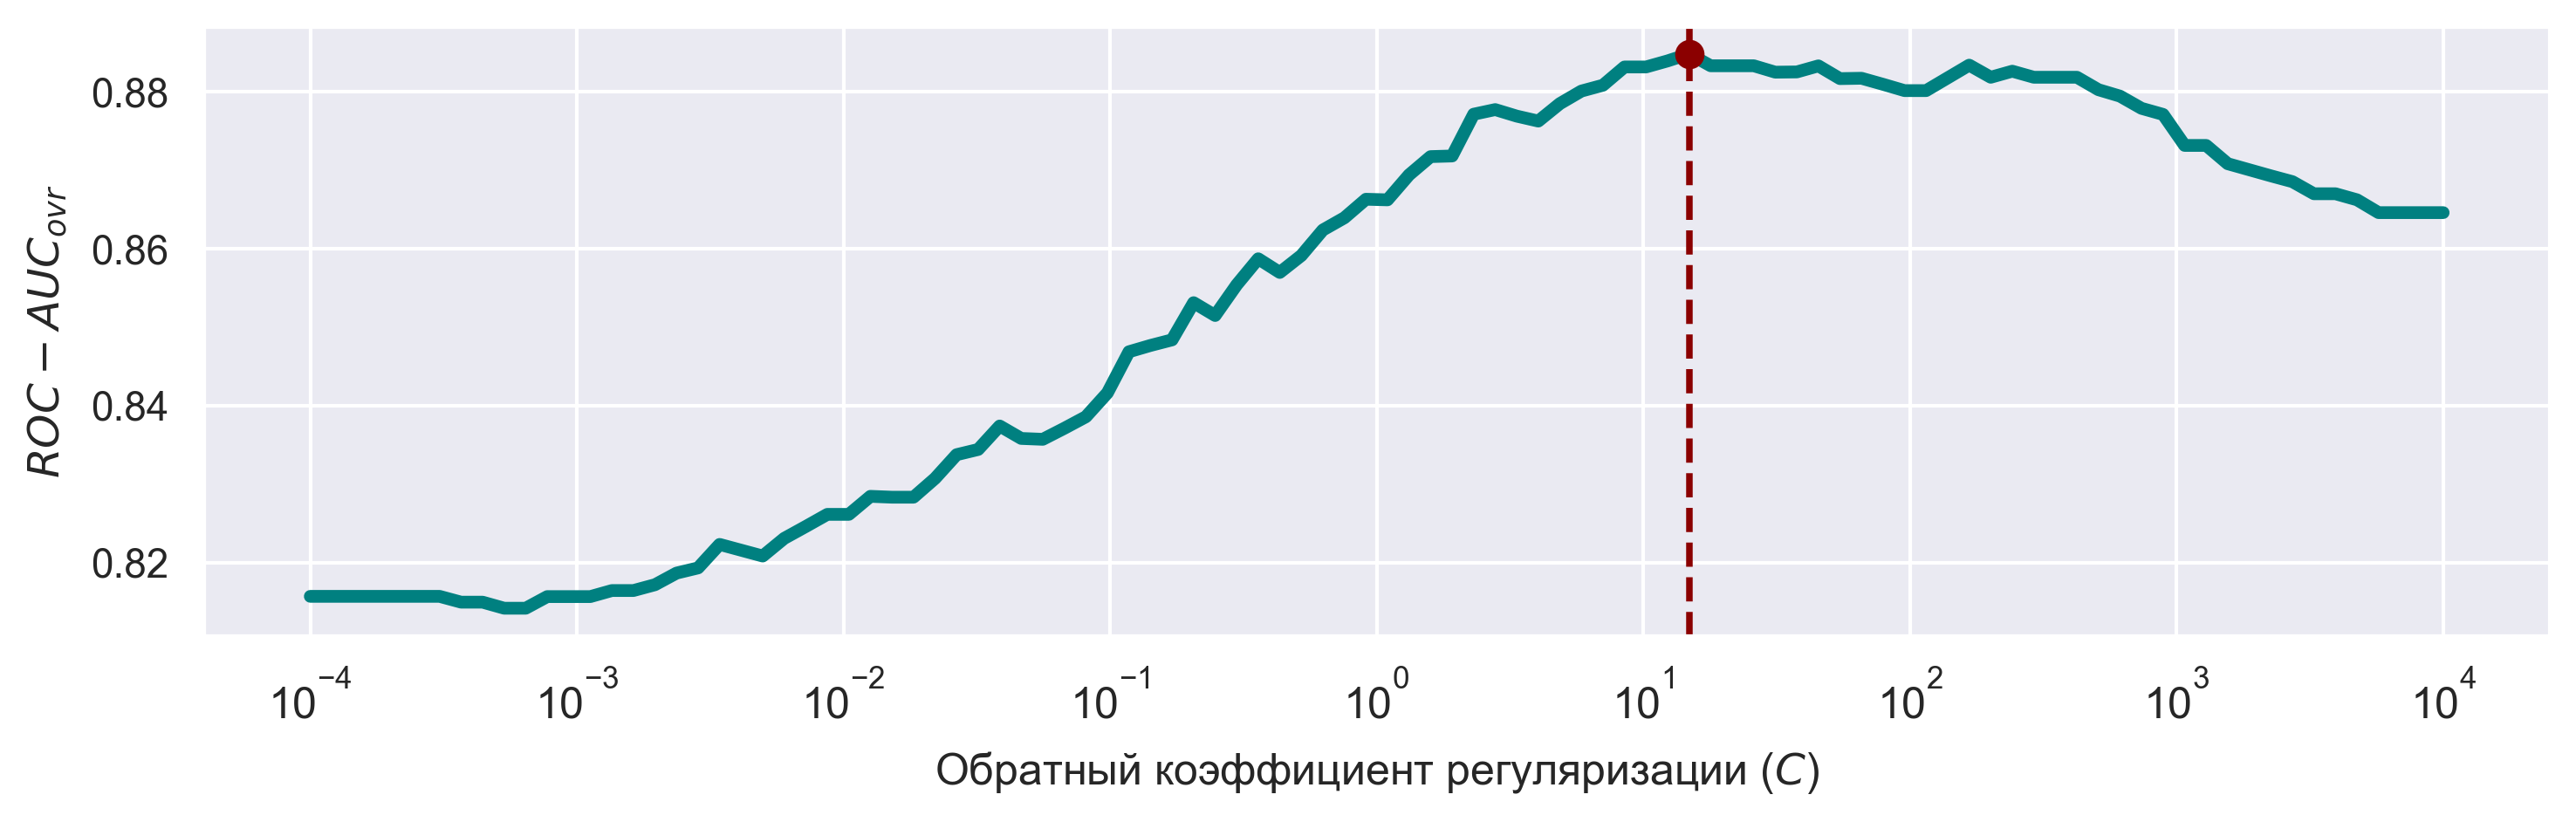

In [51]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_c_metric_curve(
    c_metric_df=c_metric_df,
    metric_name='roc_auc_ovr',
    best_C=best_C,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/c_optimization_curve_{range}.png', dpi=600)

plt.show()

#### *ROC*-curves visualization

In [52]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

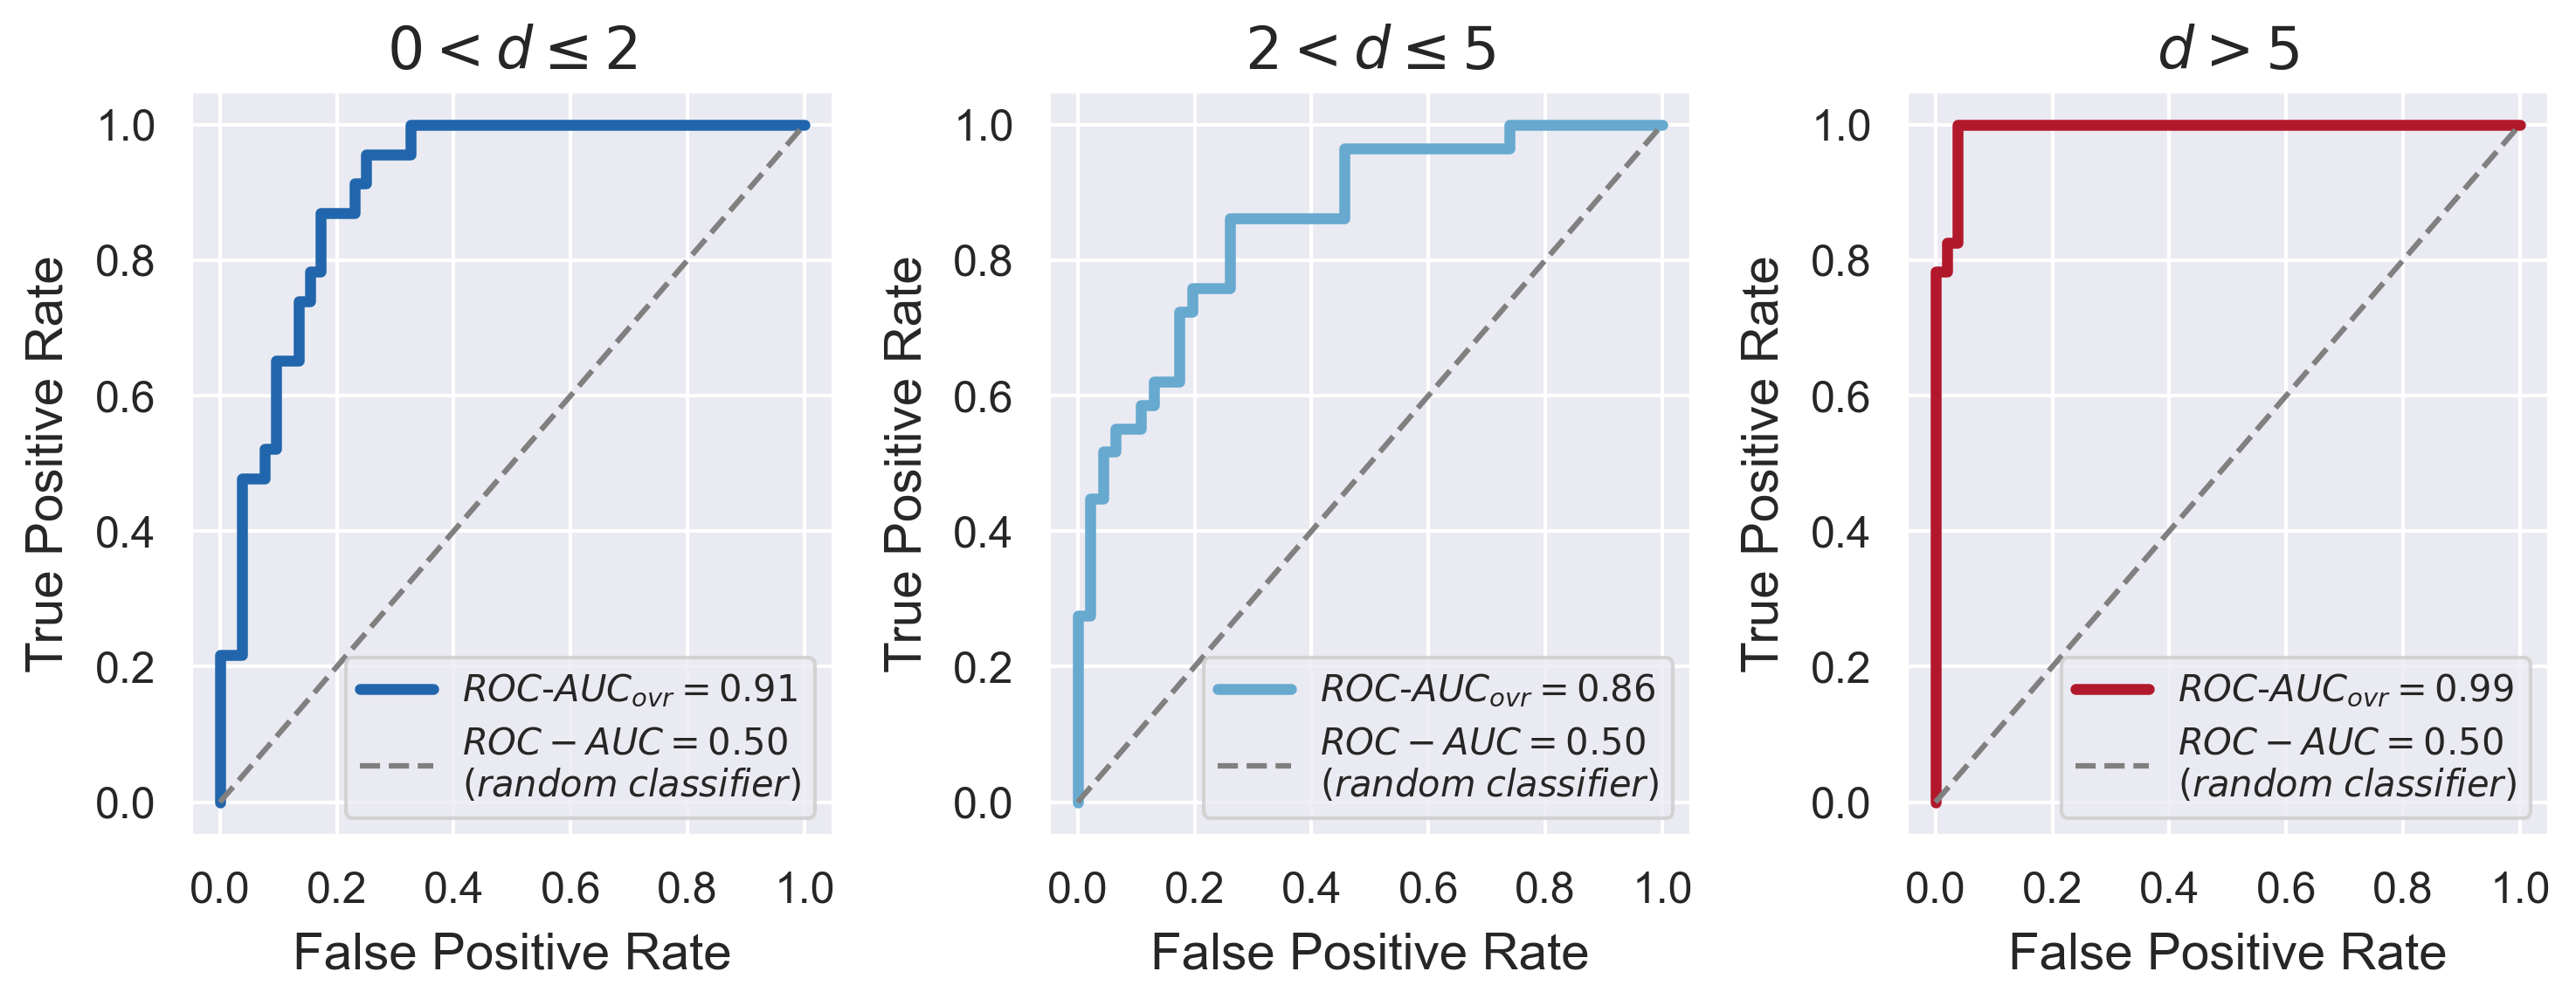

In [53]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X_scaled=X_scaled,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [54]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

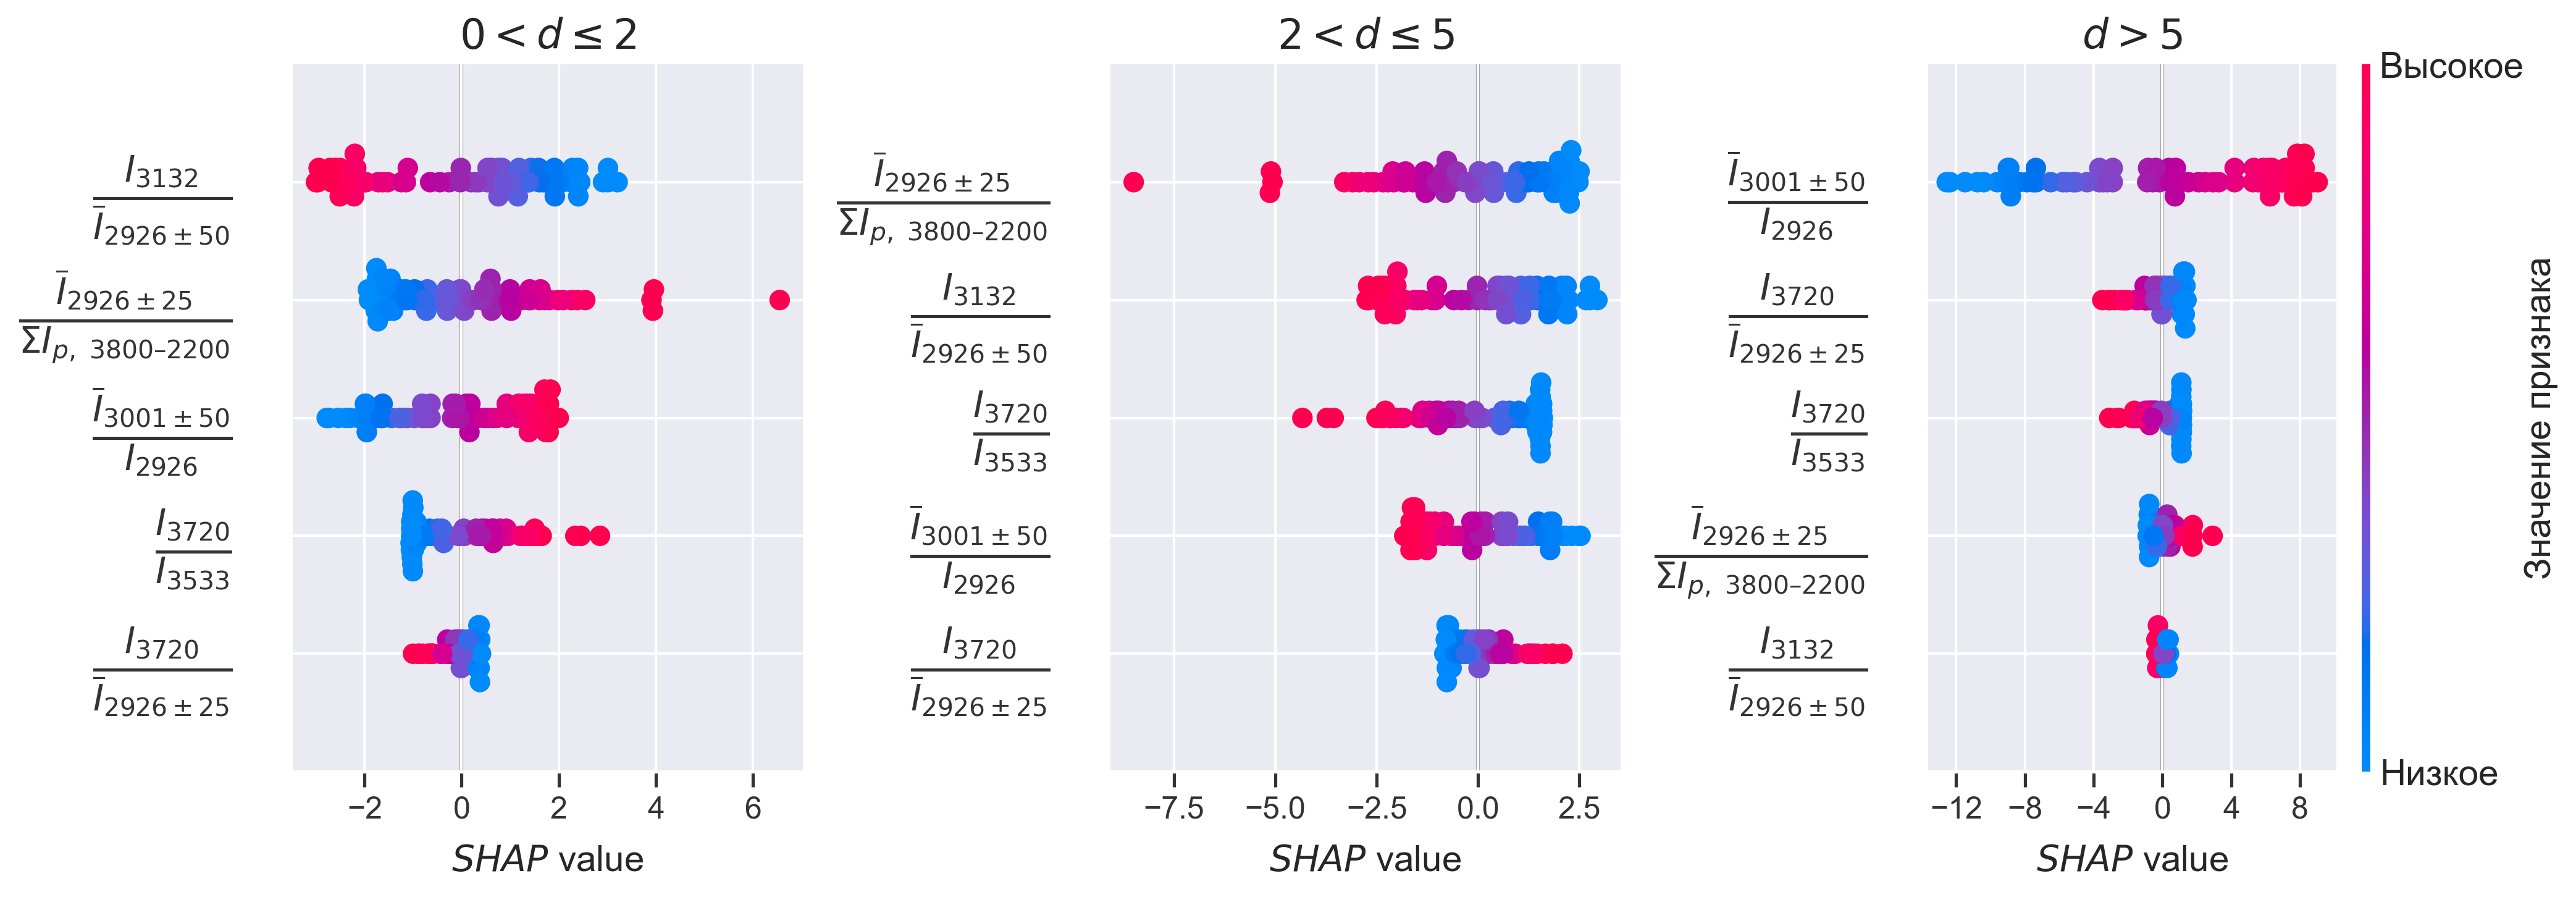

In [55]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):    
    show_colorbar = True if i == 2 else False

    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title
    
    plot_shap_summary_logreg(
        model=model,
        X_scaled=X_scaled,
        features_lst=X_scaled.columns.tolist(),
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/shap_3_subplots_{range}.png', dpi=600)

plt.show()

#### *Feature importance* diagram

In [56]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Значимость признака (доля веса), %',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_NBINS': 20,
    'PALETTE': 'crest'
}

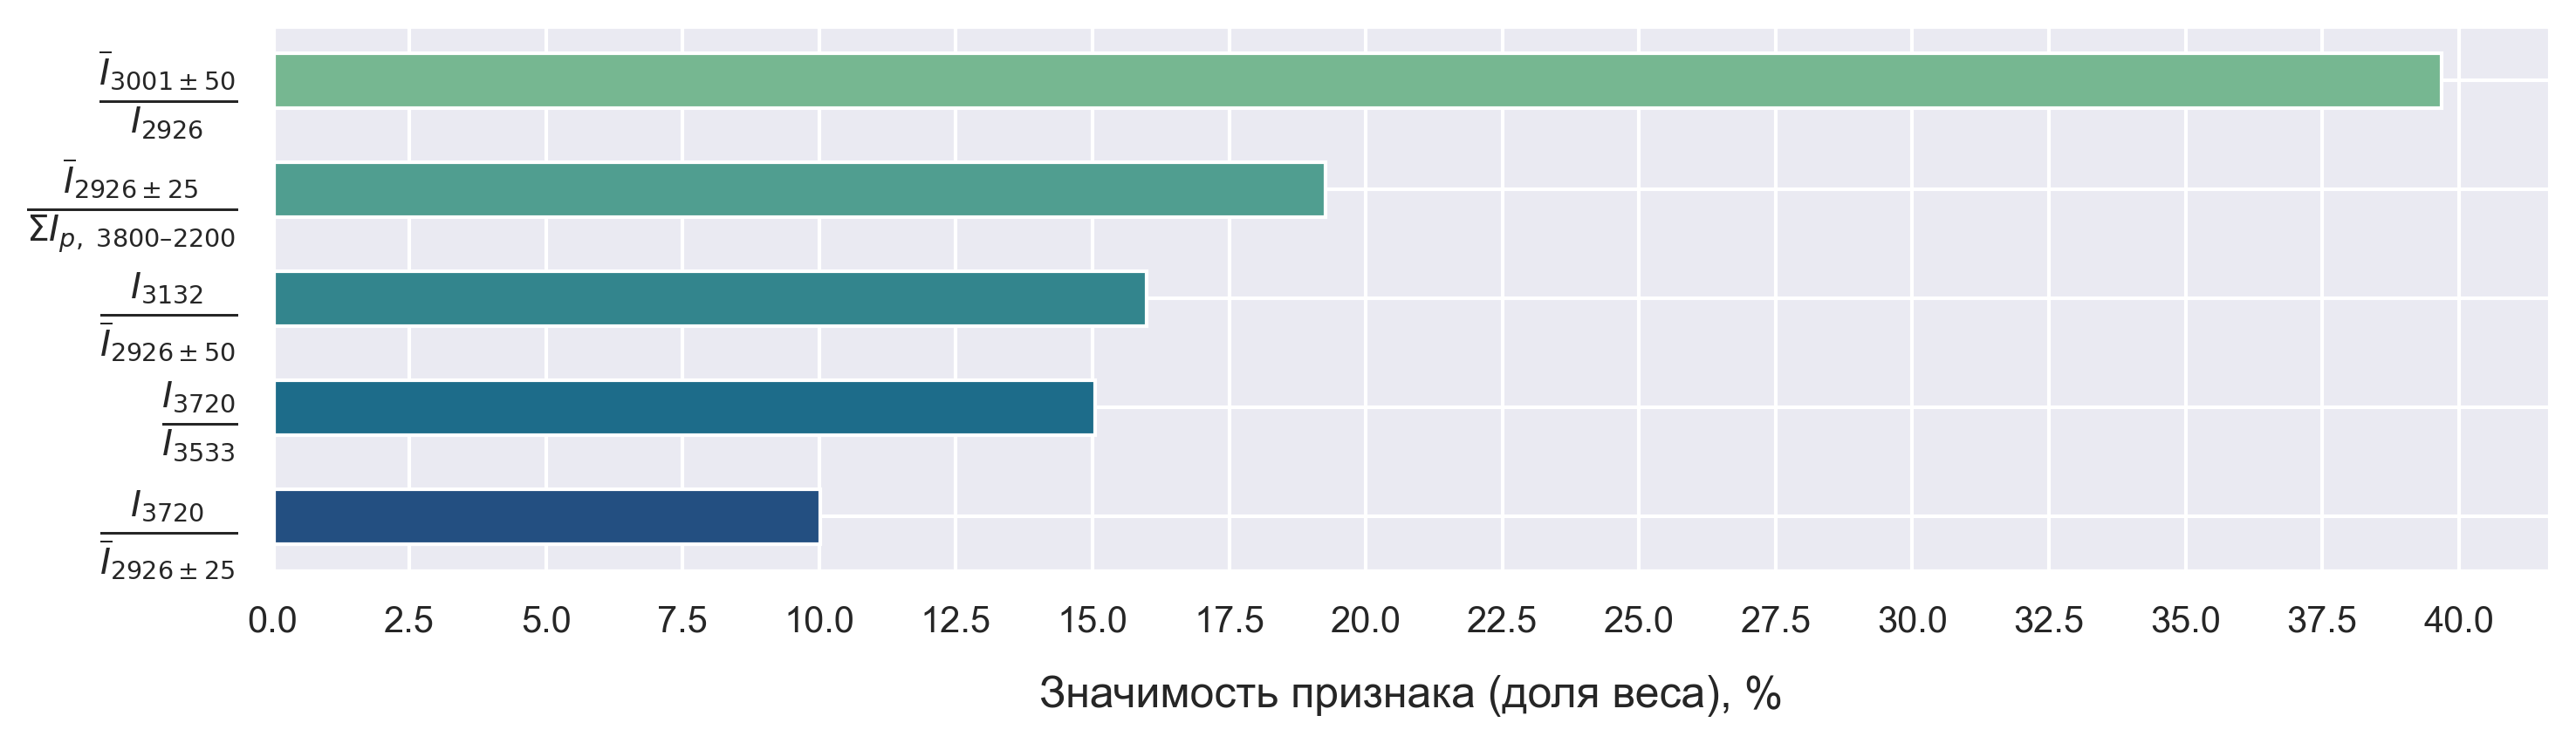

In [57]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_feature_importance_logreg(
    model=model,
    features_lst=X_scaled.columns.tolist(),
    max_display=15,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fi_barplot_{range}.png', dpi=600)

plt.show()

### `1900-800` cm$^{-1}$

In [58]:
range = '1900_800'

#### Model fitting

In [59]:
model, X_scaled, scaler_df, coef_df, metrics_df, best_C, c_metric_df = logreg_analysis(
    df=features_df,
    feature_list=selected_feats_1900_800,
    target=target,
    optimize_C=True,
    scoring_metric='roc_auc_ovr'
)

print(X_scaled.shape)
X_scaled.head(3)

Inverse of regularization strength optimization:   0%|          | 0/100 [00:00<?, ?it/s]

(75, 5)


,$\frac{I_{1651}}{I_{1609}}$,$\frac{I_{1704}}{I_{1237}}$,$\frac{I_{1737}}{I_{1704}}$,"$\frac{\overline{I}_{1584 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$",$\frac{\overline{I}_{1704 \pm 25}}{I_{1237}}$
division_1_size_bulk,-0.455169,0.074834,0.181156,0.593473,0.065467
division_1_size_5,-0.446071,0.205699,0.155632,0.565828,0.188006
division_1_size_3,-0.439250,0.305168,-0.379318,0.715881,0.285125


*Parameters for scaling*

In [60]:
display(scaler_df.T)

,0,1,2,3,4
Feature,$\frac{I_{1651}}{I_{1609}}$,$\frac{I_{1704}}{I_{1237}}$,$\frac{I_{1737}}{I_{1704}}$,"$\frac{\overline{I}_{1584 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$",$\frac{\overline{I}_{1704 \pm 25}}{I_{1237}}$
Mean,1.536856,0.740253,0.852929,0.146006,0.774407
Std,1.557493,0.391811,0.232518,0.053102,0.421853


*Model parameters (weights & intercept)*

In [61]:
display(coef_df)

,$\frac{I_{1651}}{I_{1609}}$,$\frac{I_{1704}}{I_{1237}}$,$\frac{I_{1737}}{I_{1704}}$,"$\frac{\overline{I}_{1584 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$",$\frac{\overline{I}_{1704 \pm 25}}{I_{1237}}$,Intercept
Class 0,0.192935,0.719377,-0.173383,-0.592224,0.550916,-1.064750
Class 1,-0.366949,0.020947,-0.961638,-0.551436,-0.544543,-0.546953
Class 2,-0.459292,-0.950990,1.396320,1.355299,-0.532546,-1.816360


*Model metrics*

In [62]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Mean,0.847030,0.752168
"$CI_{95, cv}$",0.045109,0.092397
$all$ $sample$,0.866221,0.749091


*Optimal inverse of regulation strength value*

#### Visualization of `C` optimization

In [63]:
print(f'Optimal value of regularization coefficient (C): {round(best_C, 4)}')

Optimal value of regularization coefficient (C): 0.9112


In [64]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3.3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Обратный коэффициент регуляризации ($C$)',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 11
}

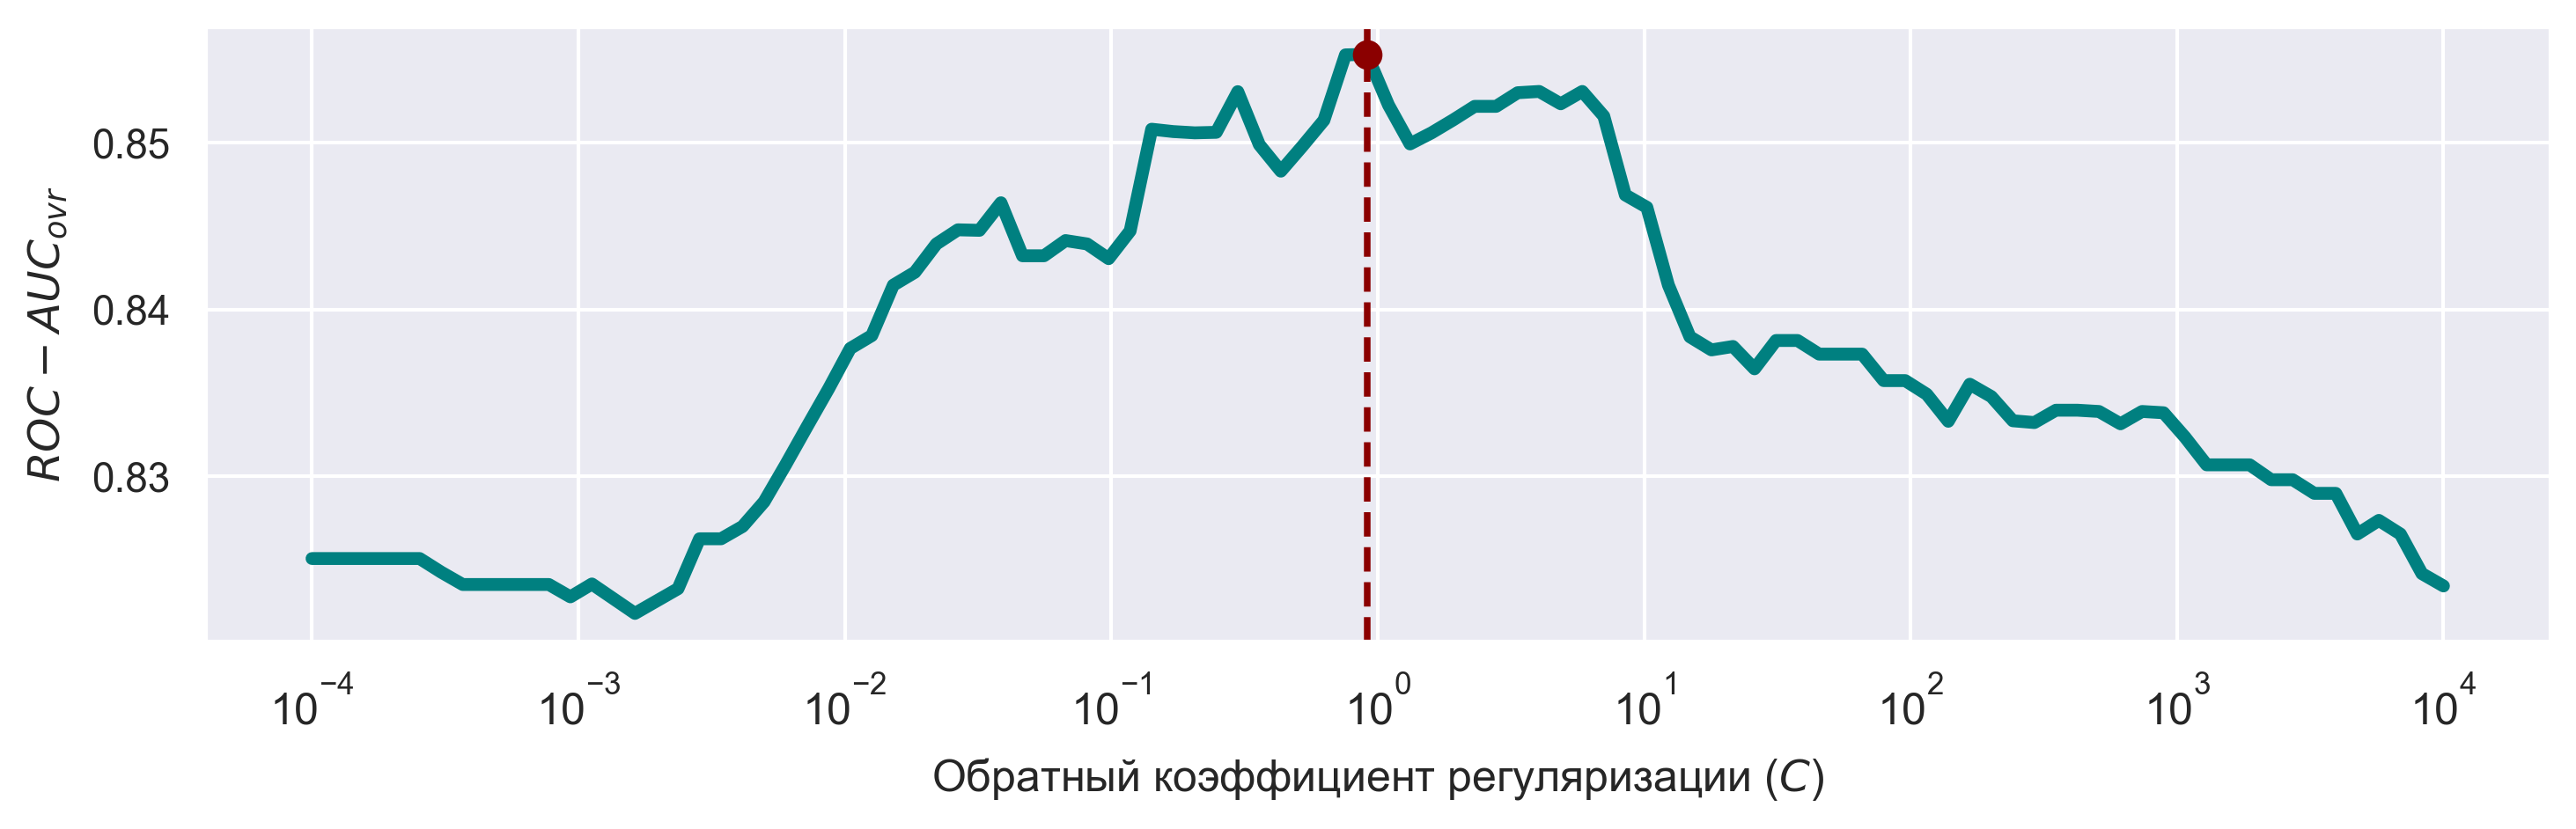

In [65]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_c_metric_curve(
    c_metric_df=c_metric_df,
    metric_name='roc_auc_ovr',
    best_C=best_C,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/c_optimization_curve_{range}.png', dpi=600)

plt.show()

#### *ROC*-curves visualization

In [66]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

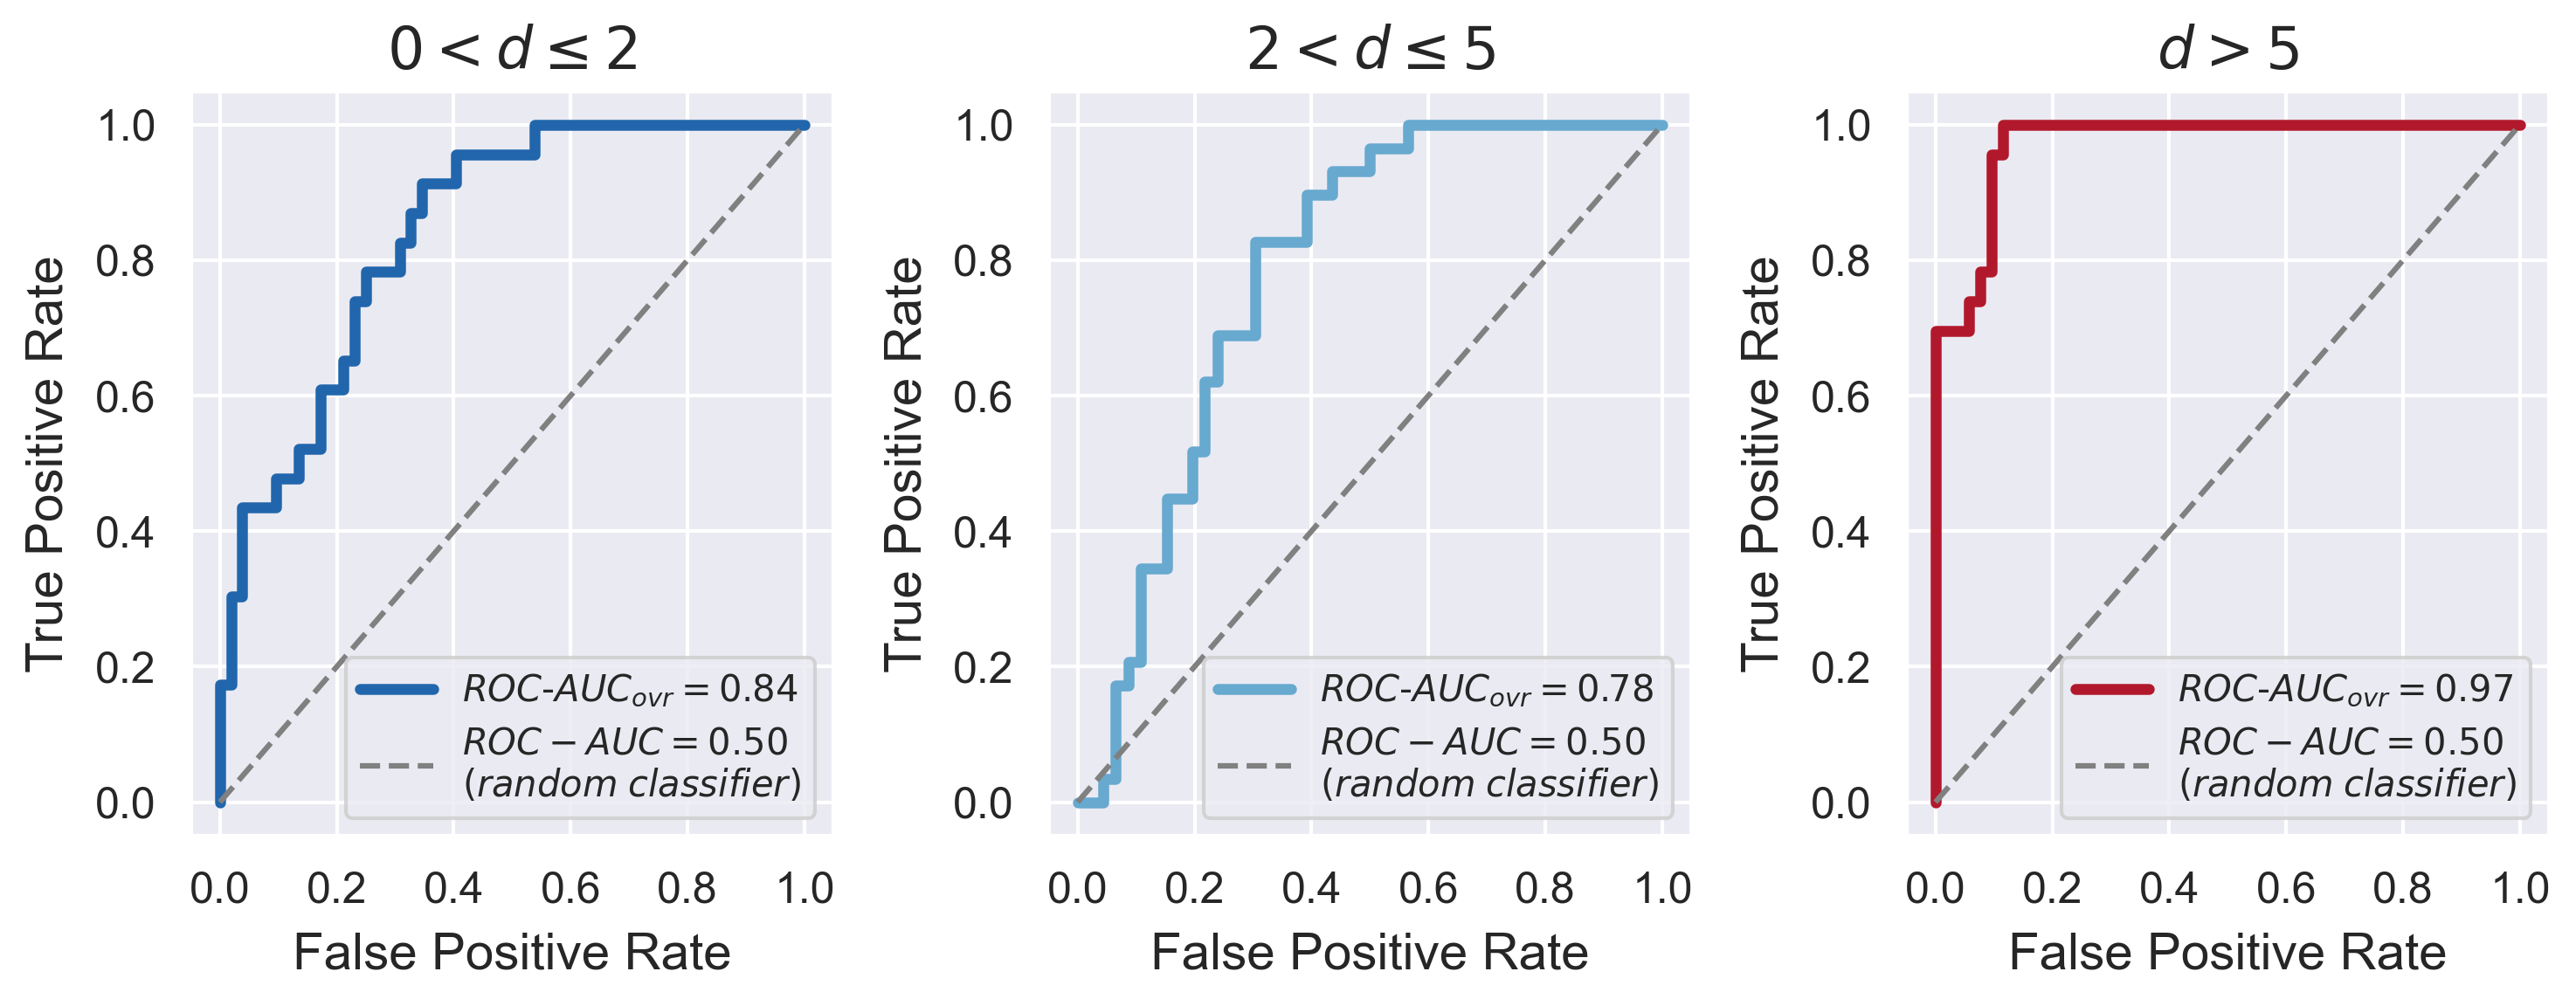

In [67]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X_scaled=X_scaled,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [68]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

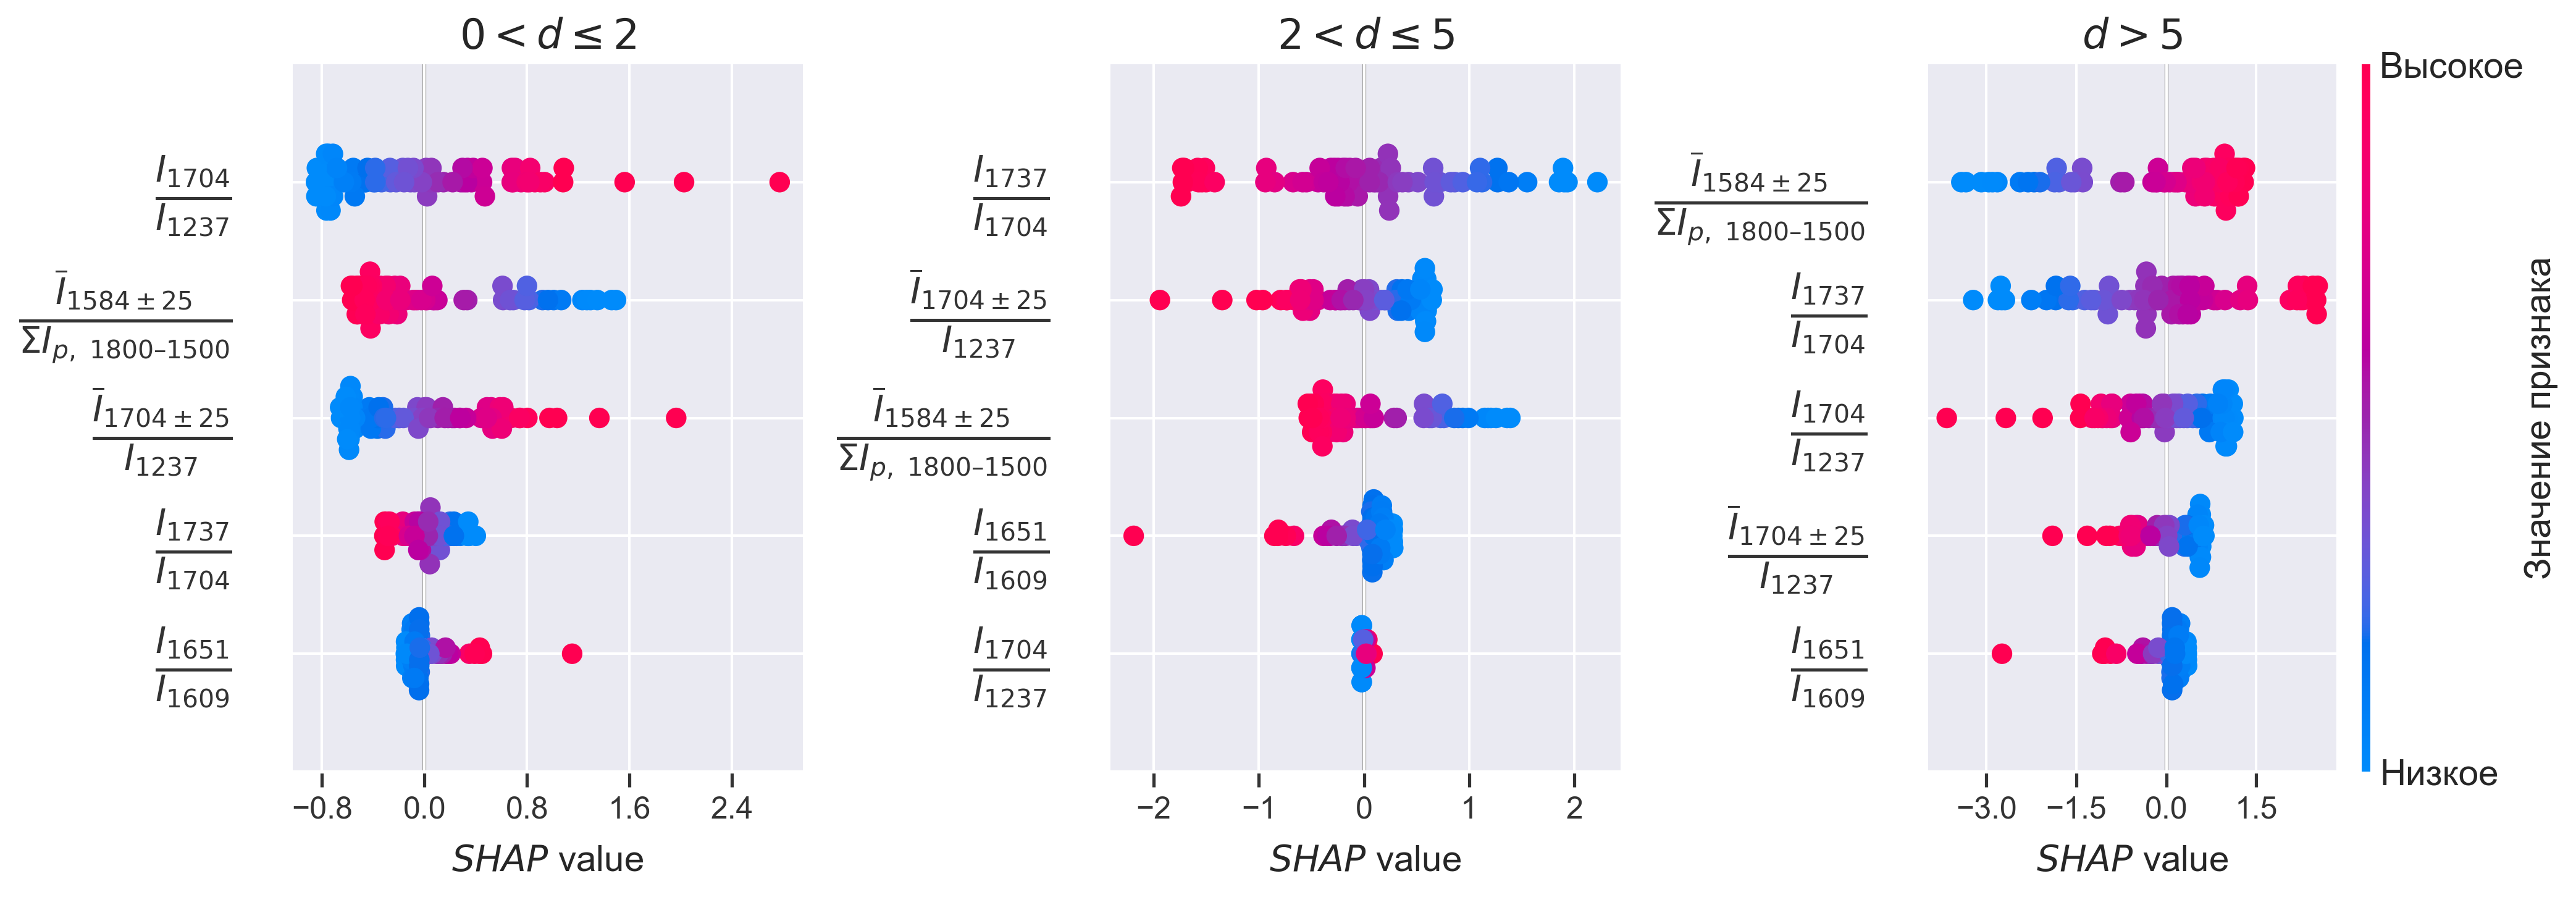

In [69]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):    
    show_colorbar = True if i == 2 else False

    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title
    
    plot_shap_summary_logreg(
        model=model,
        X_scaled=X_scaled,
        features_lst=X_scaled.columns.tolist(),
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/shap_3_subplots_{range}.png', dpi=600)

plt.show()

#### *Feature importance* diagram

In [70]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Значимость признака (доля веса), %',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_NBINS': 20,
    'PALETTE': 'crest'
}

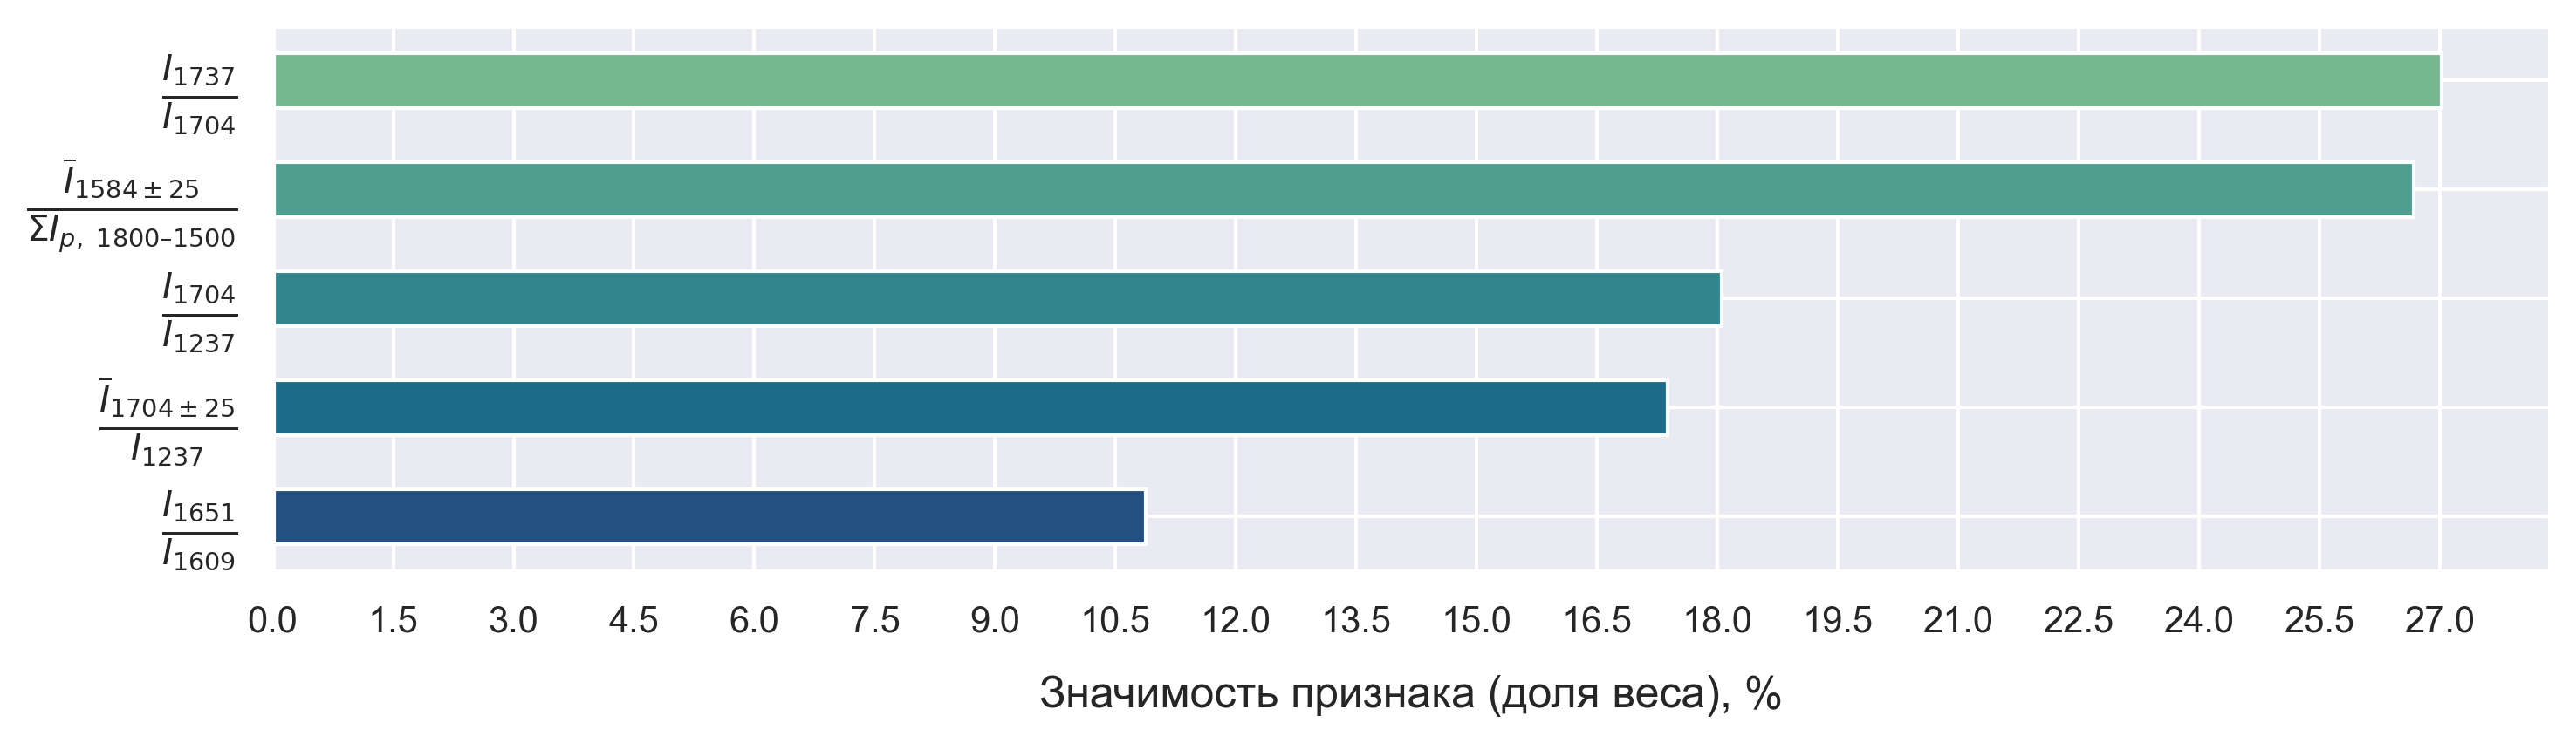

In [71]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_feature_importance_logreg(
    model=model,
    features_lst=X_scaled.columns.tolist(),
    max_display=15,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fi_barplot_{range}.png', dpi=600)

plt.show()

### `3800-2200 x 1900-800` cm$^{-1}$

In [72]:
range = '3800_2200_1900_800'

#### Model fitting

In [73]:
model, X_scaled, scaler_df, coef_df, metrics_df, best_C, c_metric_df = logreg_analysis(
    df=features_df,
    feature_list=selected_feats_3800_2200_1900_800,
    target=target,
    optimize_C=True,
    scoring_metric='roc_auc_ovr'
)

print(X_scaled.shape)
X_scaled.head(3)

Inverse of regularization strength optimization:   0%|          | 0/100 [00:00<?, ?it/s]

(75, 5)


,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,"$\frac{\overline{I}_{2926 \pm 25}}{\Sigma I_{p,\ 3800\text{–}2200}}$",$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{I_{3720}}{\overline{I}_{2926 \pm 25}}$,$\frac{I_{3720}}{I_{3533}}$
division_1_size_bulk,1.589387,-1.093607,1.234090,-0.042059,-0.650839
division_1_size_5,1.383788,-1.030590,0.933462,-0.649566,-0.918266
division_1_size_3,0.587596,-0.743796,0.108045,-0.361637,-0.755640


*Parameters for scaling*

In [74]:
display(scaler_df.T)

,0,1,2,3,4
Feature,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,"$\frac{\overline{I}_{2926 \pm 25}}{\Sigma I_{p,\ 3800\text{–}2200}}$",$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{I_{3720}}{\overline{I}_{2926 \pm 25}}$,$\frac{I_{3720}}{I_{3533}}$
Mean,0.994482,0.13069,0.833819,0.207912,0.430696
Std,0.440713,0.051839,0.286093,0.187975,0.405258


*Model parameters (weights & intercept)*

In [75]:
display(coef_df)

,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,"$\frac{\overline{I}_{2926 \pm 25}}{\Sigma I_{p,\ 3800\text{–}2200}}$",$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{I_{3720}}{\overline{I}_{2926 \pm 25}}$,$\frac{I_{3720}}{I_{3533}}$,Intercept
Class 0,-1.887715,1.689038,1.484185,-0.366291,1.002657,-1.713329
Class 1,-1.728693,-2.189519,-1.349991,0.761588,-1.524085,-0.606514
Class 2,-0.224250,0.751707,6.700139,-1.279639,-1.087730,-5.803046


*Model metrics*

In [76]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Mean,0.902200,0.858813
"$CI_{95, cv}$",0.071416,0.099513
$all$ $sample$,0.918771,0.862217


*Optimal inverse of regulation strength value*

#### Visualization of `C` optimization

In [77]:
print(f'Optimal value of regularization coefficient (C): {round(best_C, 4)}')

Optimal value of regularization coefficient (C): 14.8497


In [78]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3.3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Обратный коэффициент регуляризации ($C$)',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 11
}

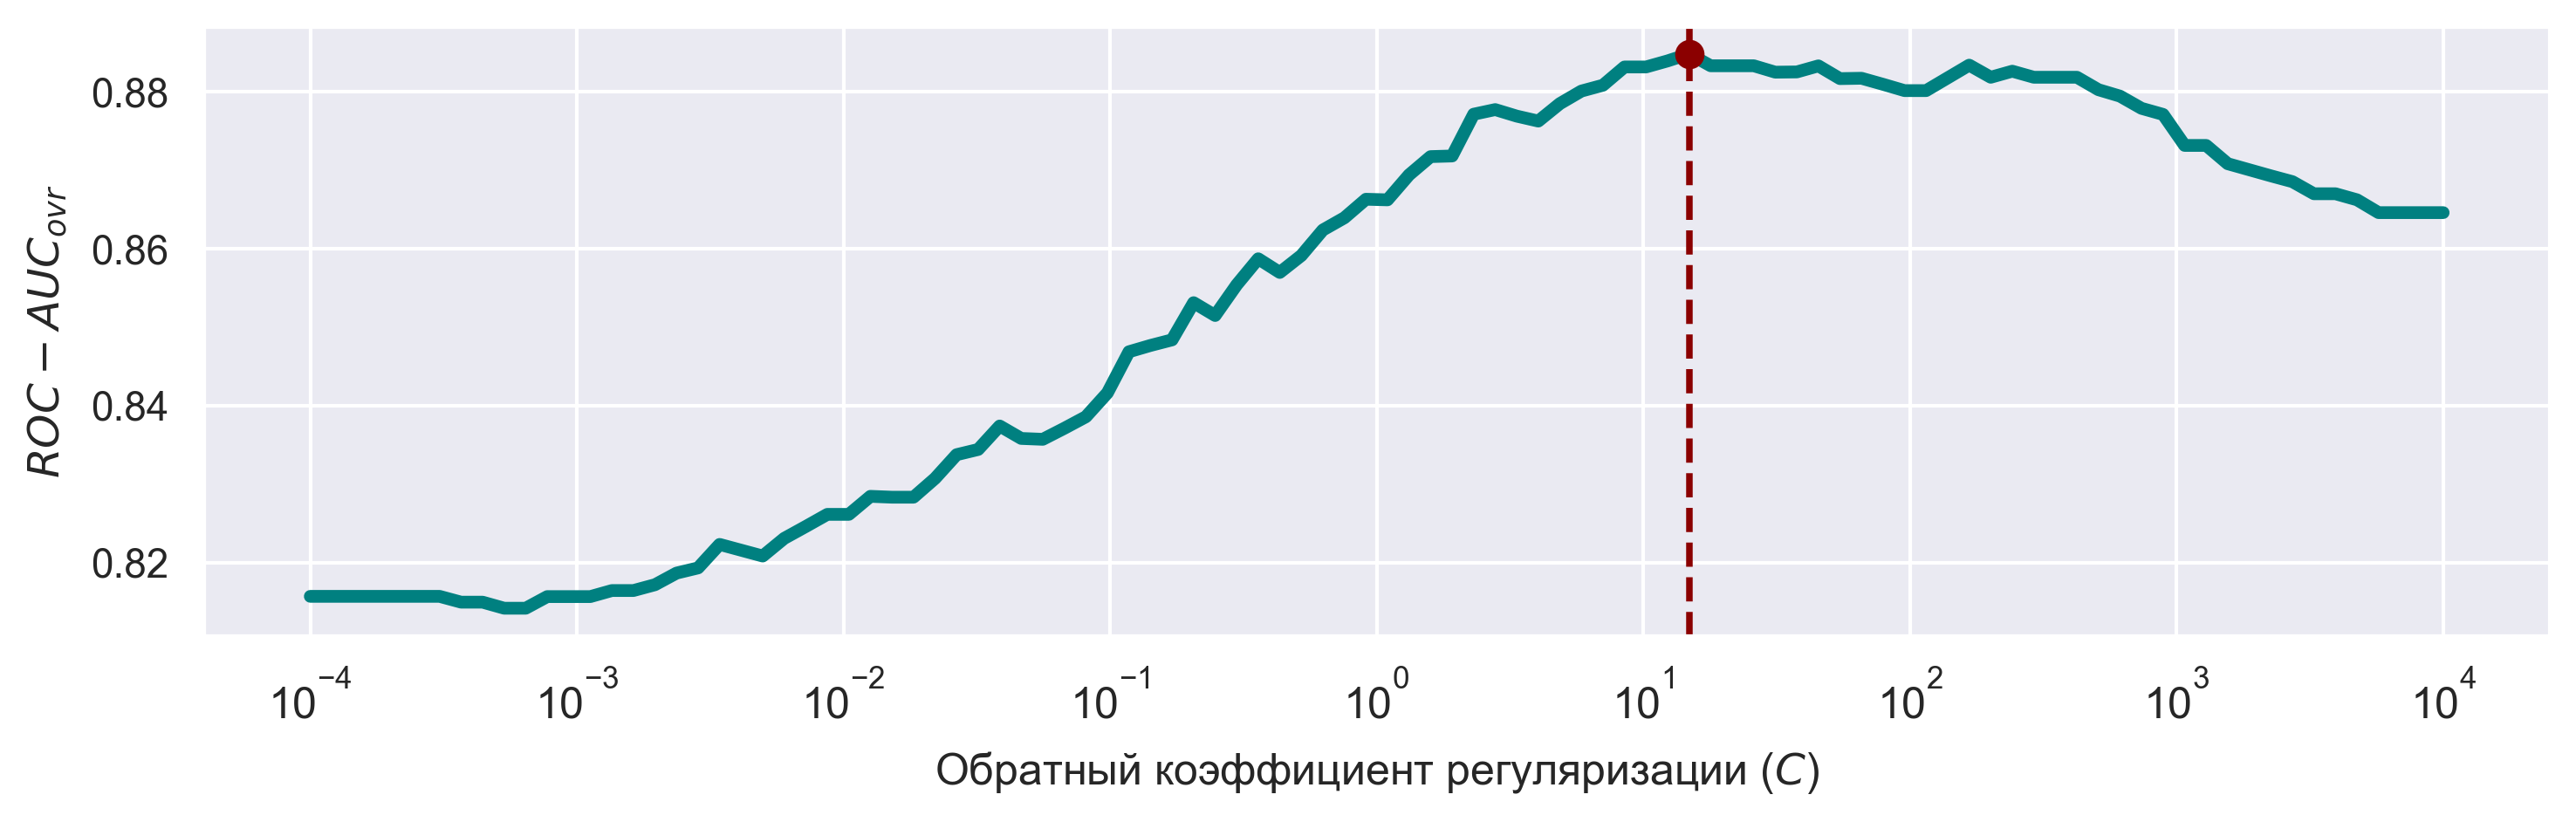

In [79]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_c_metric_curve(
    c_metric_df=c_metric_df,
    metric_name='roc_auc_ovr',
    best_C=best_C,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/c_optimization_curve_{range}.png', dpi=600)

plt.show()

#### *ROC*-curves visualization

In [80]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

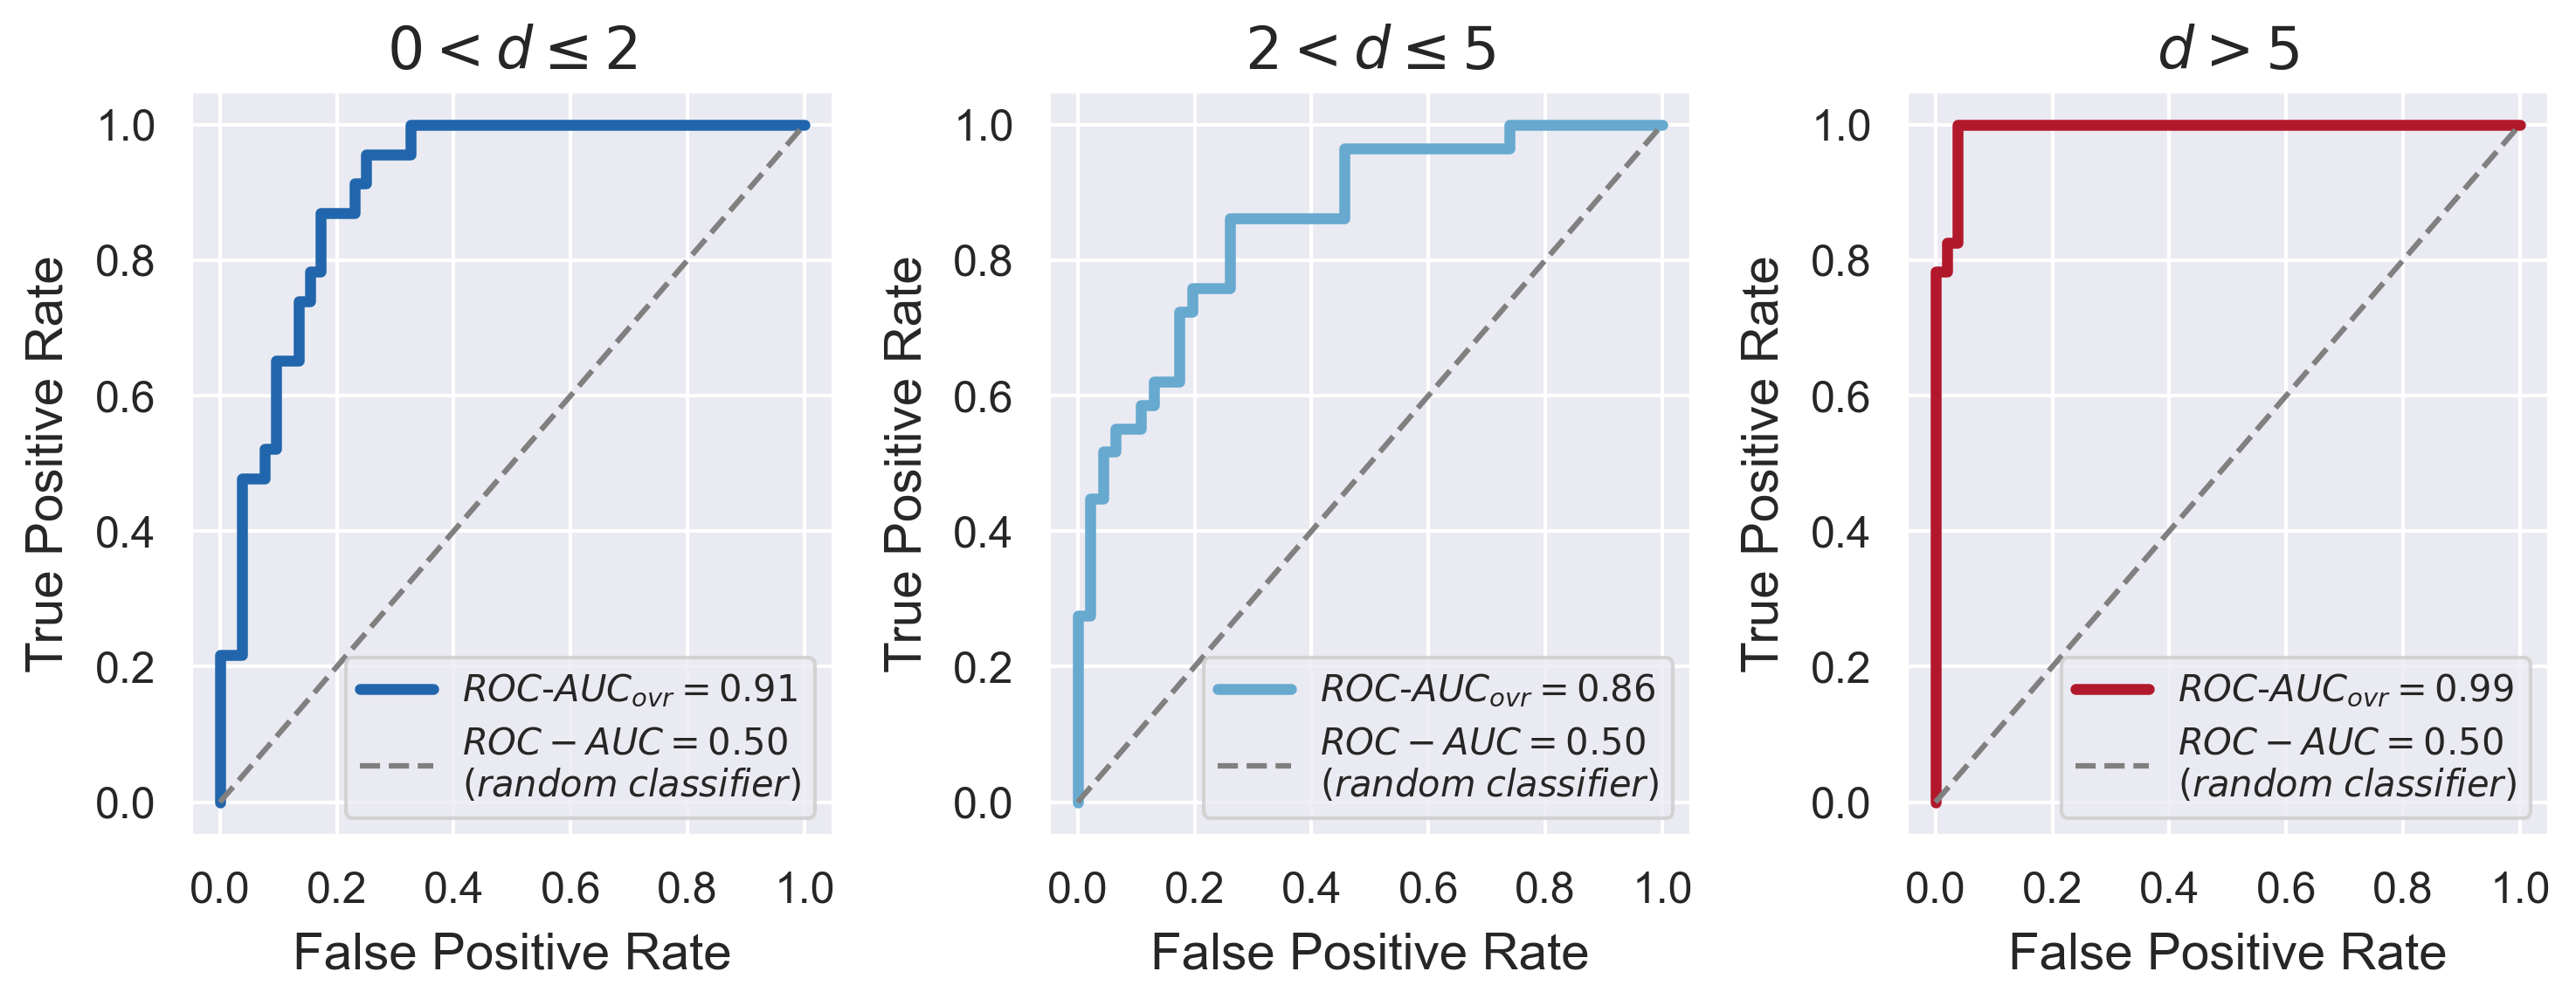

In [81]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X_scaled=X_scaled,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [82]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

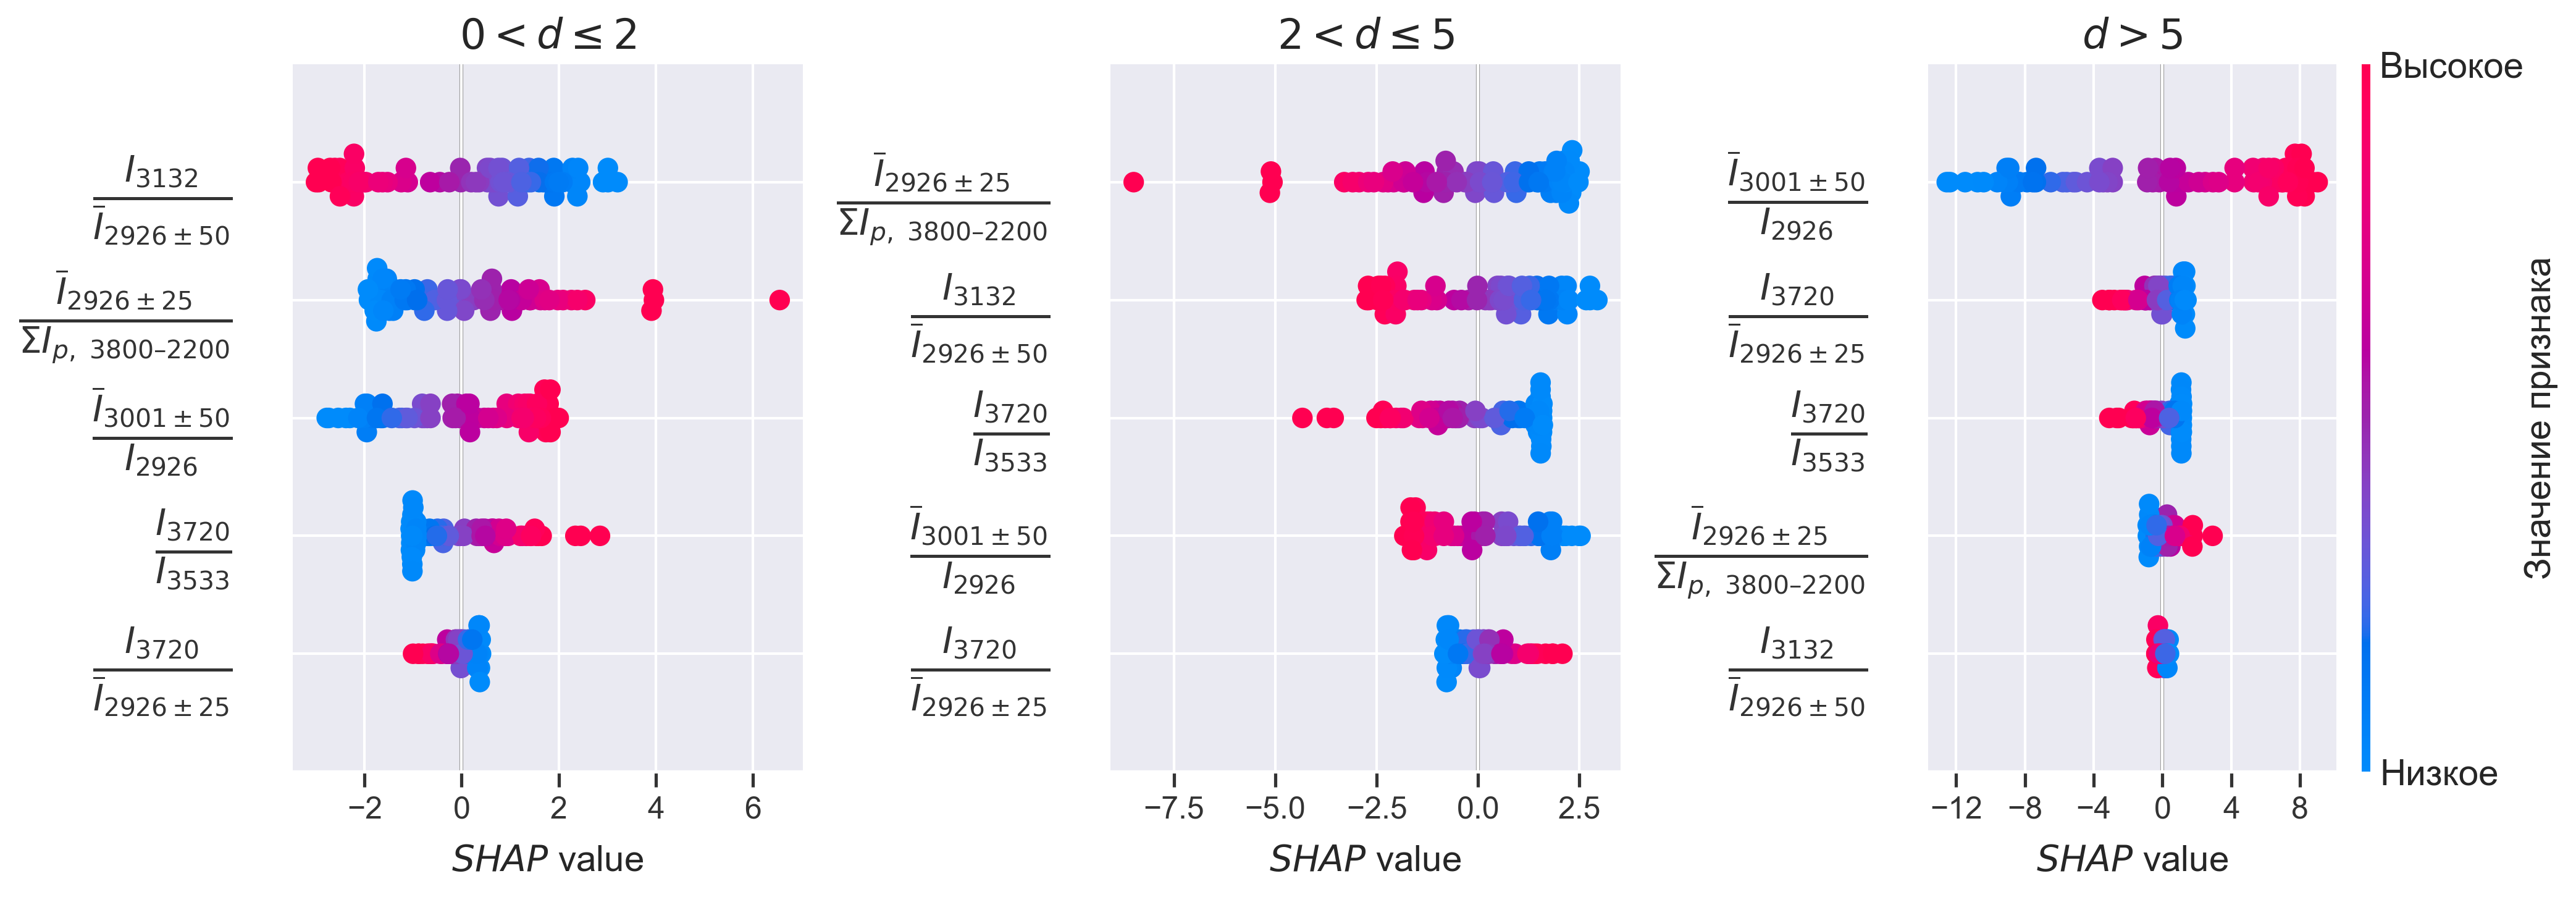

In [83]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):    
    show_colorbar = True if i == 2 else False

    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title
    
    plot_shap_summary_logreg(
        model=model,
        X_scaled=X_scaled,
        features_lst=X_scaled.columns.tolist(),
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/shap_3_subplots_{range}.png', dpi=600)

plt.show()

#### *Feature importance* diagram

In [84]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Значимость признака (доля веса), %',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_NBINS': 20,
    'PALETTE': 'crest'
}

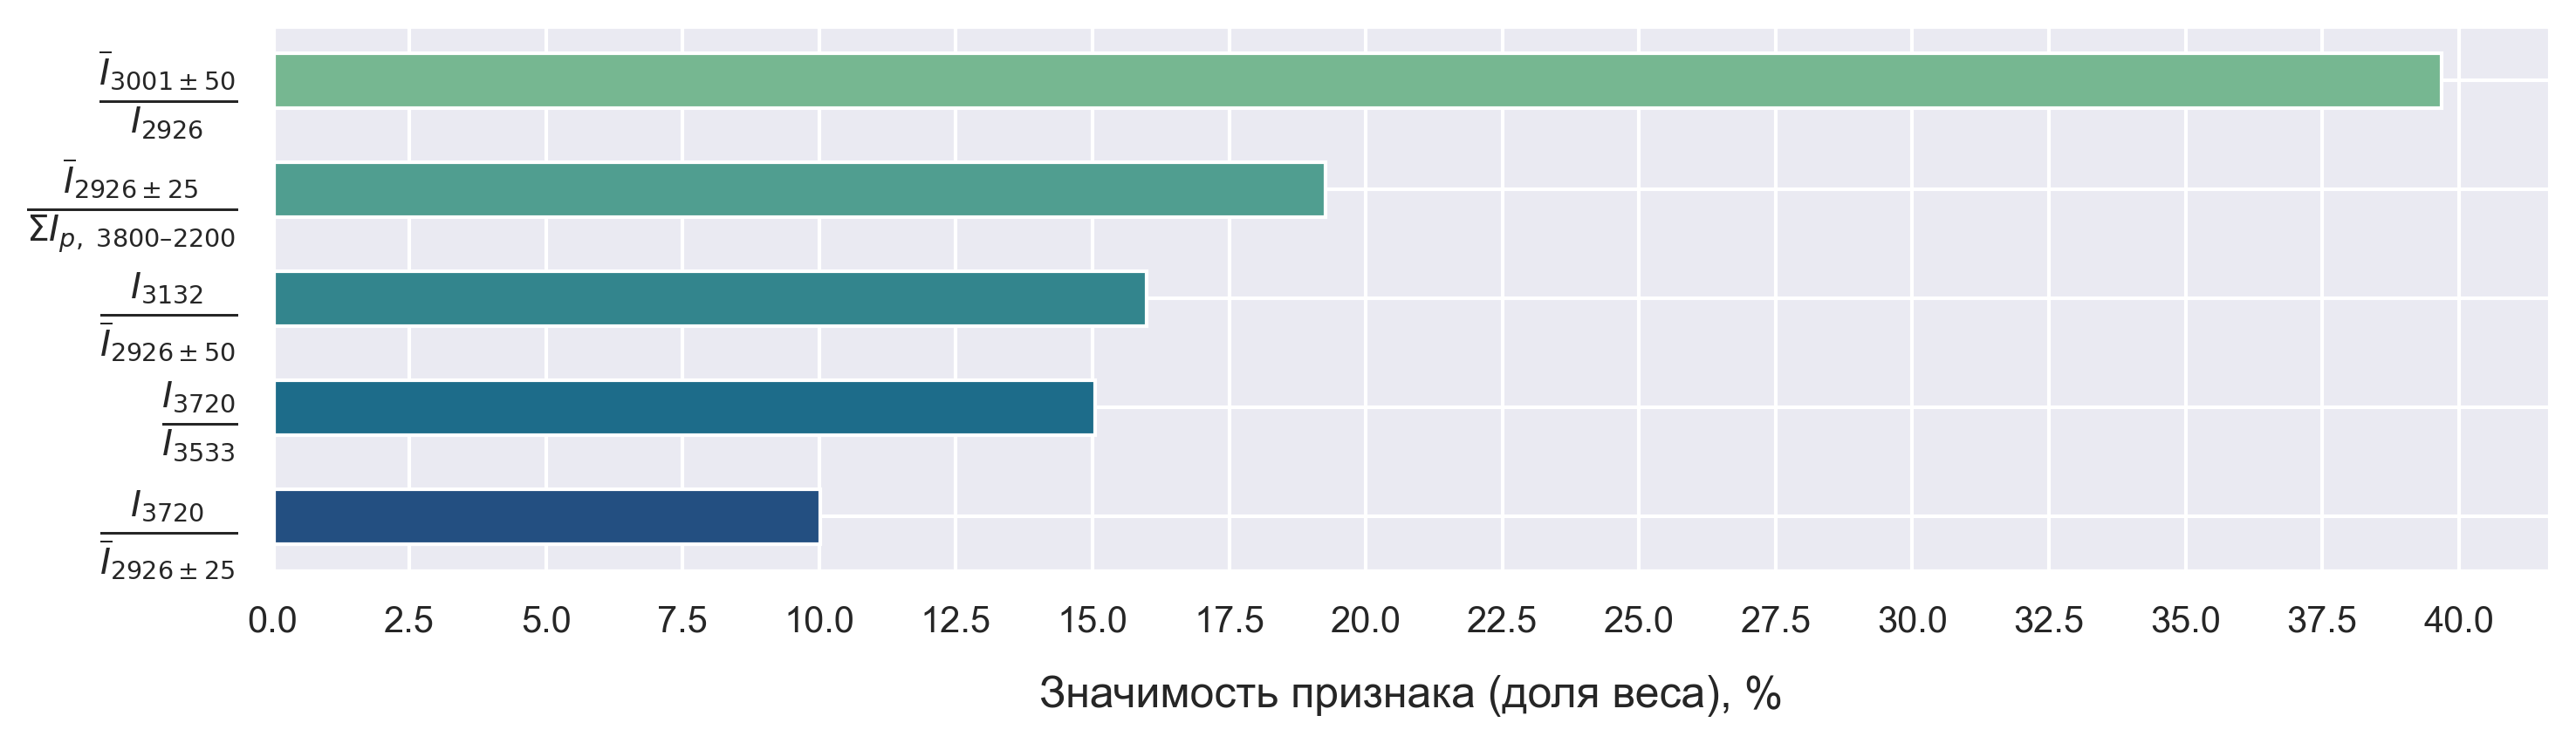

In [85]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_feature_importance_logreg(
    model=model,
    features_lst=X_scaled.columns.tolist(),
    max_display=15,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fi_barplot_{range}.png', dpi=600)

plt.show()